# Исследование Игровых платформ (Сборный проект 1)

В нашем распоряжении данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) до 2016 года. Планируется рекламная кампания на 2017-й.

**Цель исследования:**
Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


**Ход исследования**

Проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе исследовательского анализа поищем возможность исправить самые критичные ошибки данных. И напоследок проверим гипотезы.
 
Таким образом, исследование пройдёт в четыре этапа:
 1. Подготовка данных.
 2. Исследовательский анализ данных.
 3. Проверка гипотез.
 4. Общий вывод.

## 1. Подготовка данных

### Откроем файл с данными и изучим общую информацию:

In [1]:
# Импортируем необходимые, в ходе исследования, библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
data = pd.read_csv('C:\\StudentYandex\\Projekts\\Python\\Projekt5Sbornuy\\games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Выводы**

В каждой строке таблицы — данные о игре. Часть колонок описывает саму игру: название, жанр, год выпуска, оценка критиков, оценка пользователей и возрастное ограничение по данным ESRB. Остальные данные рассказывают о продажах: в каком регионе сколько было продано копий.

Предварительно можно утверждать, что данных достаточно для проверки гипотезы. Но встречаются пропуски в данных, а в названиях колонок — расхождения с хорошим стилем.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

### Проведем предобработку данных:

**Приведем названия колонок к хорошему стилю**:

In [4]:
data.columns = [column.lower() for column in data.columns] # Приводим названия столбцов к нижнему регистру 
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**Заполним пропуски в данных**:

In [5]:
data.isna().sum() # Посмотрим на количество пропусков в столбцах

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [6]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm') 
# Расчитаем % пропусков от общего количества строк

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Удаляем строки с пропущенными значениями в столбцах `name`, `year_of_release`, `genre`.
Данные нужны для исследования.Но пропусков в этих столбцах менее 2 % от всего датафрейма- не повлияет на ход исследования.

In [7]:
data = data.dropna(subset=['name', 'year_of_release', 'genre'])

In [8]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Пропуски в столбцах `critic_score` и `user_score` нам очень важны для исследования. По всей видимости возникли в следствие того, что на платформах где выходили эти игры, оценку поставить было невозможно, либо по техническим причинам. Рассмотрим их повнимательней.

In [9]:
data['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

In [10]:
data[data['critic_score'].isna()]['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

Пропуски данных имеются в каждом жанре, чтобы не искажать результат исследования оставим эти значения оставим как есть.

In [11]:
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

В массиве уникальных значений `user_score`, помимо пропущенных, имеется значение "tbd". Посмотрим отдельно на эти строки: 

In [12]:
data.loc[data['user_score'] == 'tbd'].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
726,Dance Dance Revolution X2,PS2,2009.0,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
821,The Incredibles,GBA,2004.0,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999.0,Misc,1.94,0.00,0.00,0.00,NaN,tbd,E
1047,Tetris Worlds,GBA,2001.0,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E
1048,Imagine: Teacher,DS,2008.0,Simulation,0.70,0.82,0.00,0.19,NaN,tbd,E


TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков, которые надо заполнить, в информации требований. 

(Источник: https://www.mobilradio.ru/information/vocabulary/tbd.htm)



Таким образом Оценка пользователей по данным играм еще не определена, заполним ее как пропущенные значения `nan`.

In [13]:
for i in data['genre'].unique():
    data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

Пропуски в столбце `rating`. ESRB рейтинг это рейтинг для США и Канады. Значения пропущенны не из-за технической ошибки. Заполним их значением `no_rating`

«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».

«E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первой игрой, которая получила данный рейтинг, стала The Simpsons Cartoon Studio, выпущенная в 1996 году.

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года. Первой игрой, которая получила данный рейтинг, стала Donkey Kong: Jungle Beat.

«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

«M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением. Большинство таких игр предназначено для персональных компьютеров под управлением Microsoft Windows и Apple Macintosh. Рейтинг «Только для взрослых» является предметом многочисленных дискуссий, так как накладывает серьёзные ограничения на продажи игры. Первой игрой, которая получила данный рейтинг, стала The Joy of Sex, выпущенная в 1993 году.

«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

«RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»: Продукт отправлен ESRB на оценку, но примерное содержание близко к рейтингу «M». Данная маркировка была введена с 2021 г. и распространяется на демо или презентационный вариант.

(Источник: https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board)

In [14]:
data['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

In [15]:
data['rating'] = data['rating'].fillna('no_rating')
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

**Изменим типы данных**:

Тип данных в столбце `year_of_release` - поменяем на `int`, год же не можеть быть с дробной частью. Плюс на графиках данные значения будут отображатся красивее. 

In [16]:
data['year_of_release'] = data['year_of_release'].astype('int')

Тип данных в столбце `user_score` - поменяем на float. Эти данные нам потребуются в дальнейшем исследовании для сравнения в числовом формате.

In [17]:
data['user_score'] = data['user_score'].astype('float')

Добавим столбец `total_sales` и поместим в него суммарные продажи во всех регионах.

In [18]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no_rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no_rating,31.38


**Проверим наличие явных дубликатов**

In [19]:
data.duplicated().sum()

0

**Выводы:**

Предобработка обнаружила две проблемы в данных:

- нарушения в стиле заголовков,
- пропущенные значения.

Мы исправили заголовки, чтобы упростить работу с таблицей.

Часть пропущенных значения оставили как есть, чтобы не исказить данные и не прийти к неверному выводу. 

Пропуске в столбце `rating` за менили на `no_rating`, так как данные нам не известы, а заменить их на "что-то среднее" неправильно, по той причине что рейтинг ESBN строиться для США и Канады, а мы изучием не только их.

Удалили те строки, где пропущенные значения заполнить не представляется возможным, но они не повлияют на ход исследования так как их менее 2%. 

Теперь можно перейти к исследовательскому анализу. 

## 2. Исследовательский анализ данных. 

Посмотрим сколько игр выпускалось в разные годы и построим график по этим данным:

In [20]:
quantity_games = data.groupby('year_of_release').agg(quantity=('name','count'))
print(quantity_games)

                 quantity
year_of_release          
1980                    9
1981                   46
1982                   36
1983                   17
1984                   14
1985                   14
1986                   21
1987                   16
1988                   15
1989                   17
1990                   16
1991                   41
1992                   43
1993                   60
1994                  121
1995                  219
1996                  263
1997                  289
1998                  379
1999                  338
2000                  350
2001                  482
2002                  829
2003                  775
2004                  762
2005                  939
2006                 1006
2007                 1197
2008                 1427
2009                 1426
2010                 1255
2011                 1136
2012                  653
2013                  544
2014                  581
2015                  606
2016        

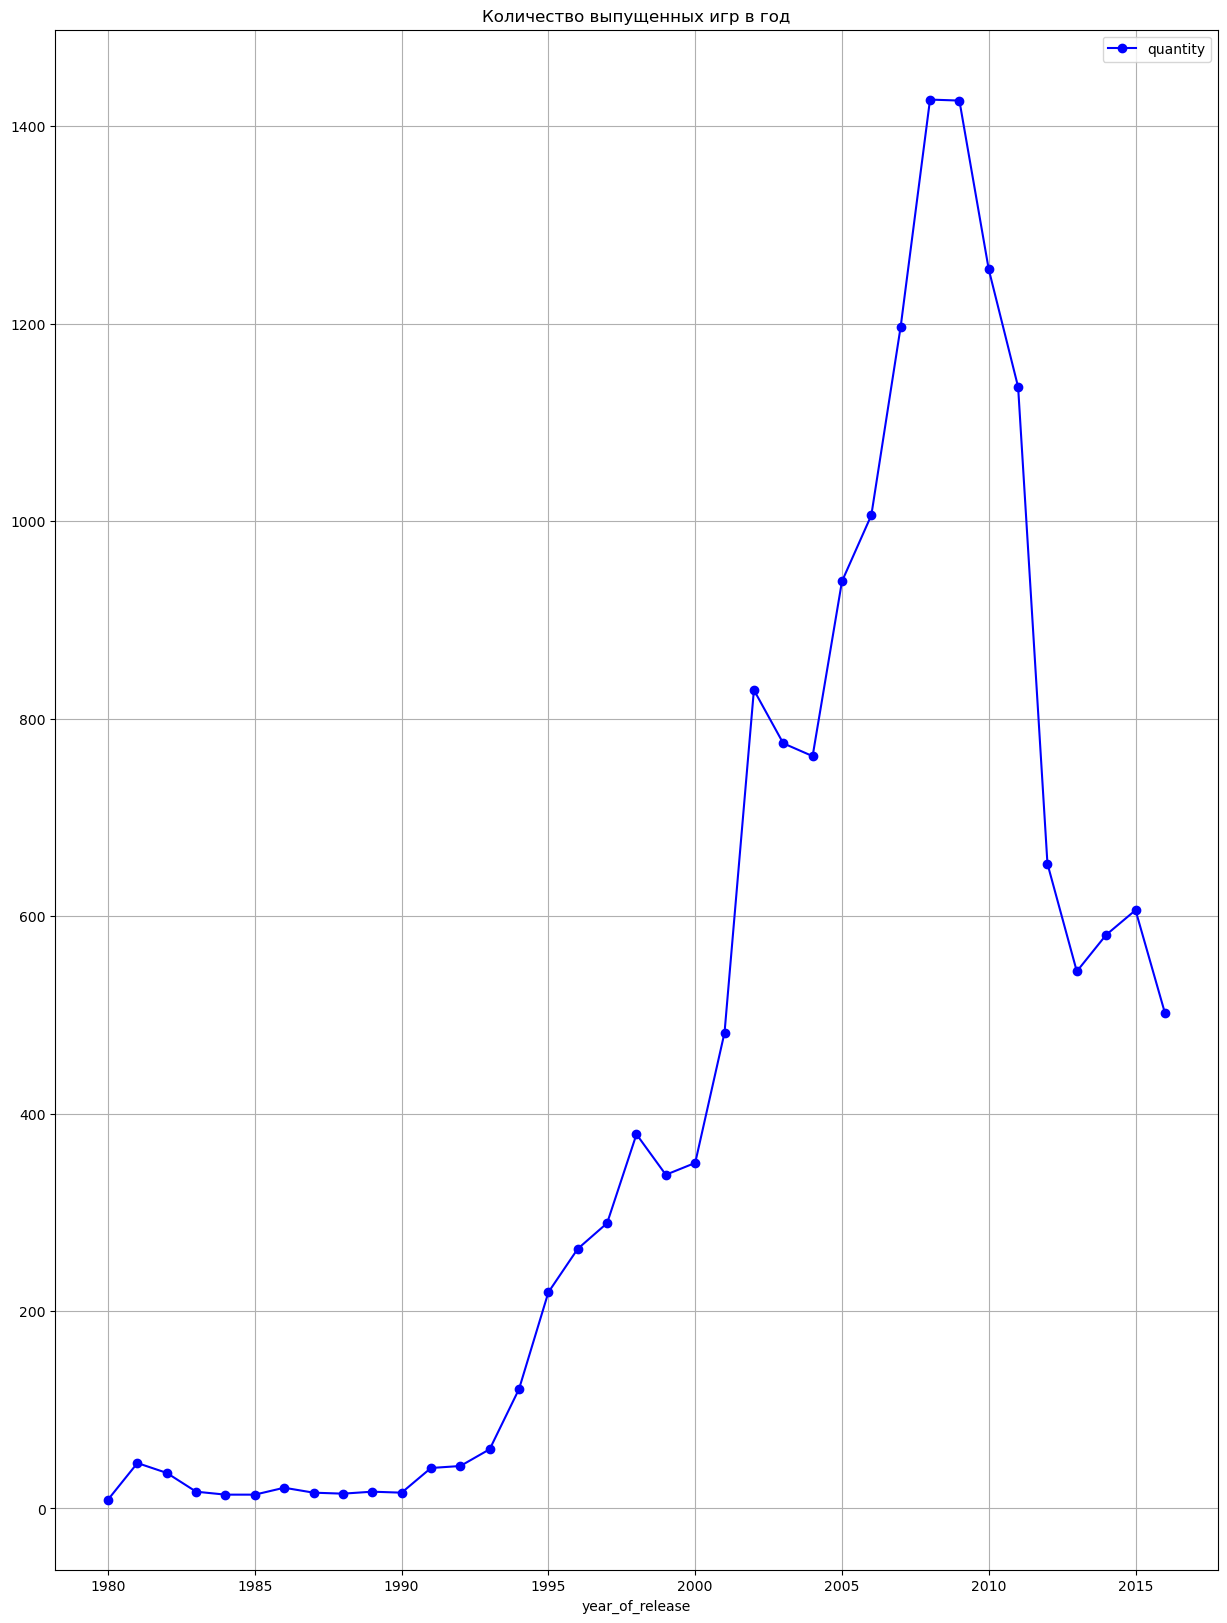

In [21]:
quantity_games.plot(style = 'o-', c ='blue', grid = True, figsize = (15,20), title='Количество выпущенных игр в год' )
plt.show()

На графике и в цифрах видим:
* с 1980 по 2001 годы было выпущенно крайне мало игр; 
* Количество игр выпущенных в 2008-2009 годах самое больше.

Так как нам надо прогнозировать рекламную компанию на 2017 год. Выявим лидеров с 2001 года.

In [22]:
data = data.loc[data['year_of_release'] >= 2001]

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Выясним за какой характерный срок появляются новые и исчезают старые платформы.

In [23]:
top_10 = data.groupby(['platform'])['total_sales'].sum().sort_values(ascending=False).head(10)
top_10

platform
PS2     1194.39
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS4      314.14
GBA      312.81
PSP      289.53
3DS      257.81
XB       250.58
Name: total_sales, dtype: float64

In [24]:
print('10 платформ с наибольшими суммарными продажами:', top_10.index.tolist())

10 платформ с наибольшими суммарными продажами: ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS4', 'GBA', 'PSP', '3DS', 'XB']


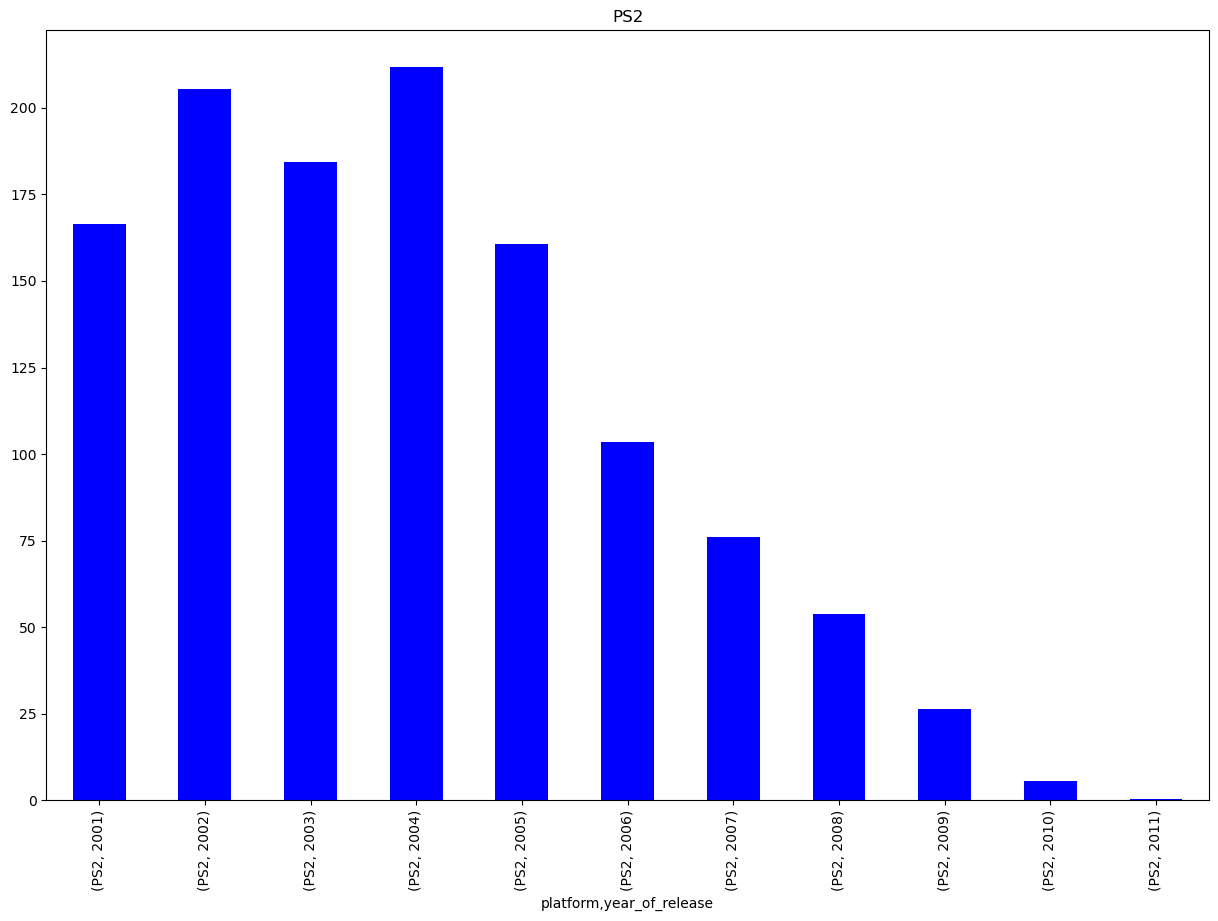

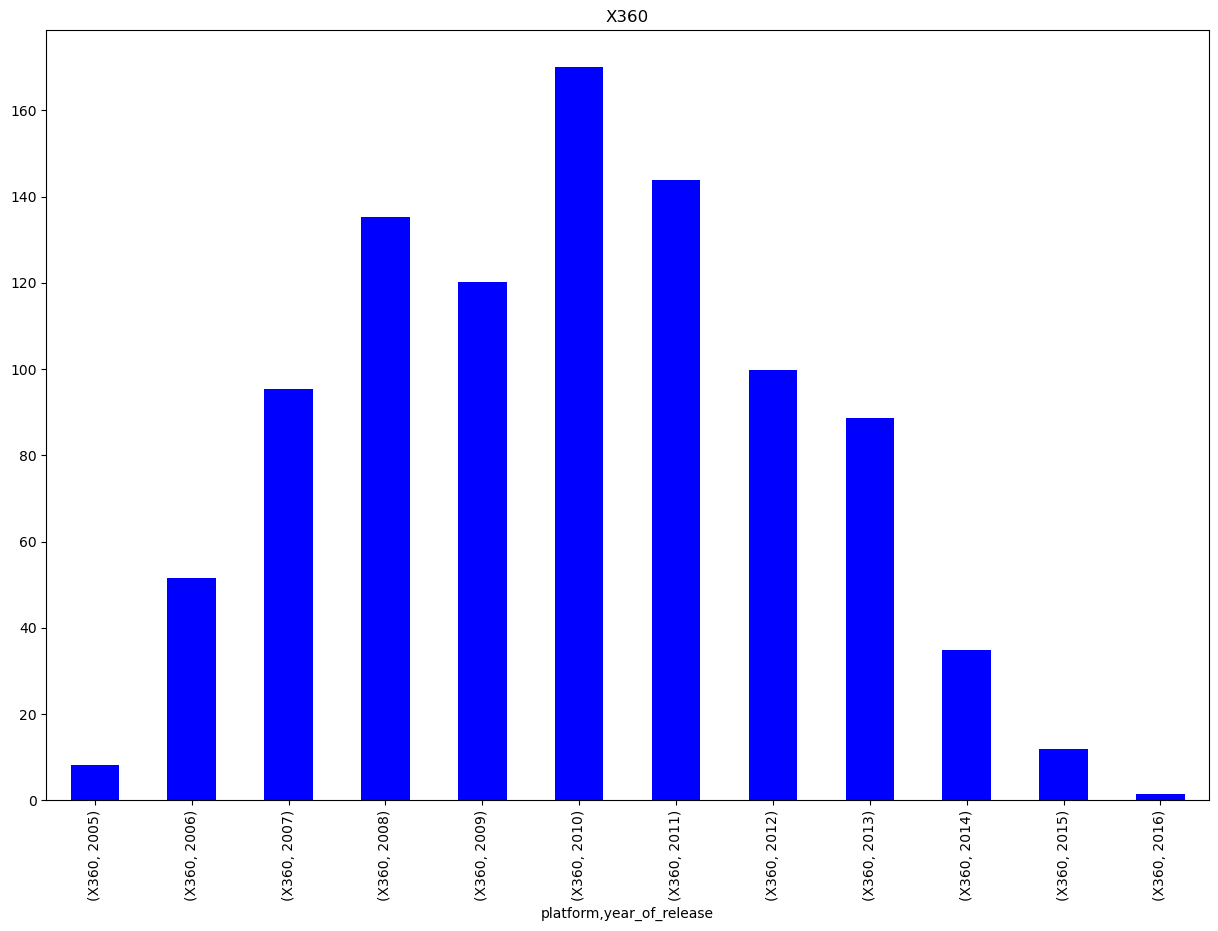

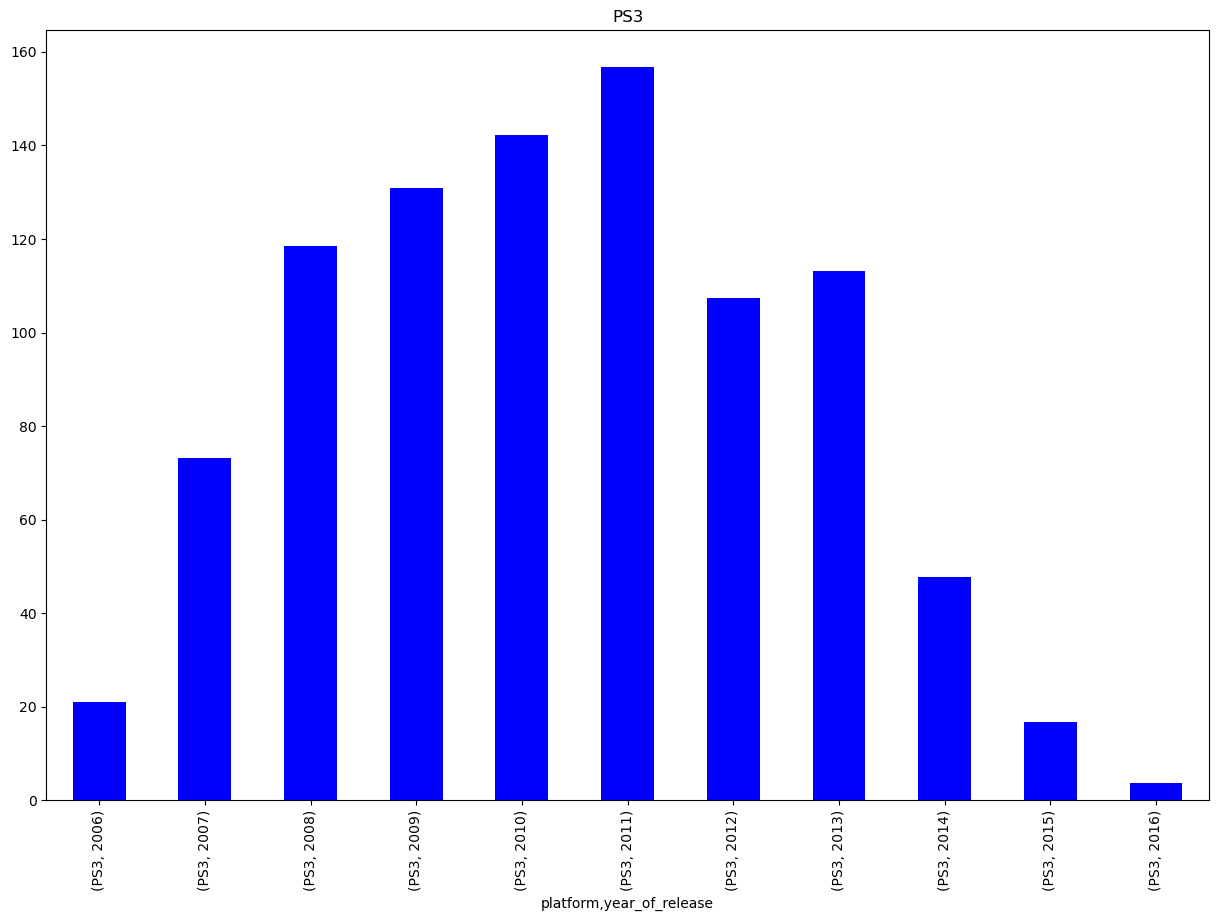

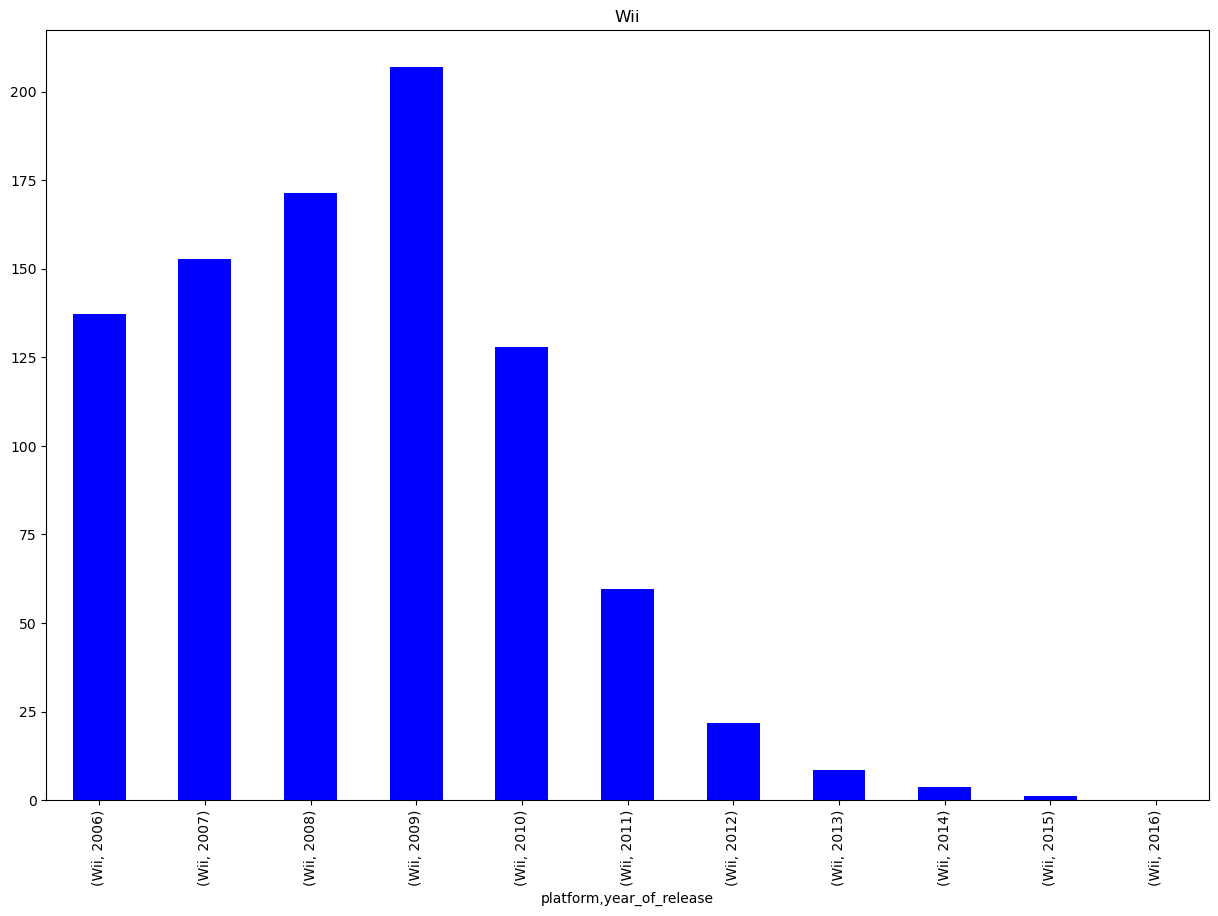

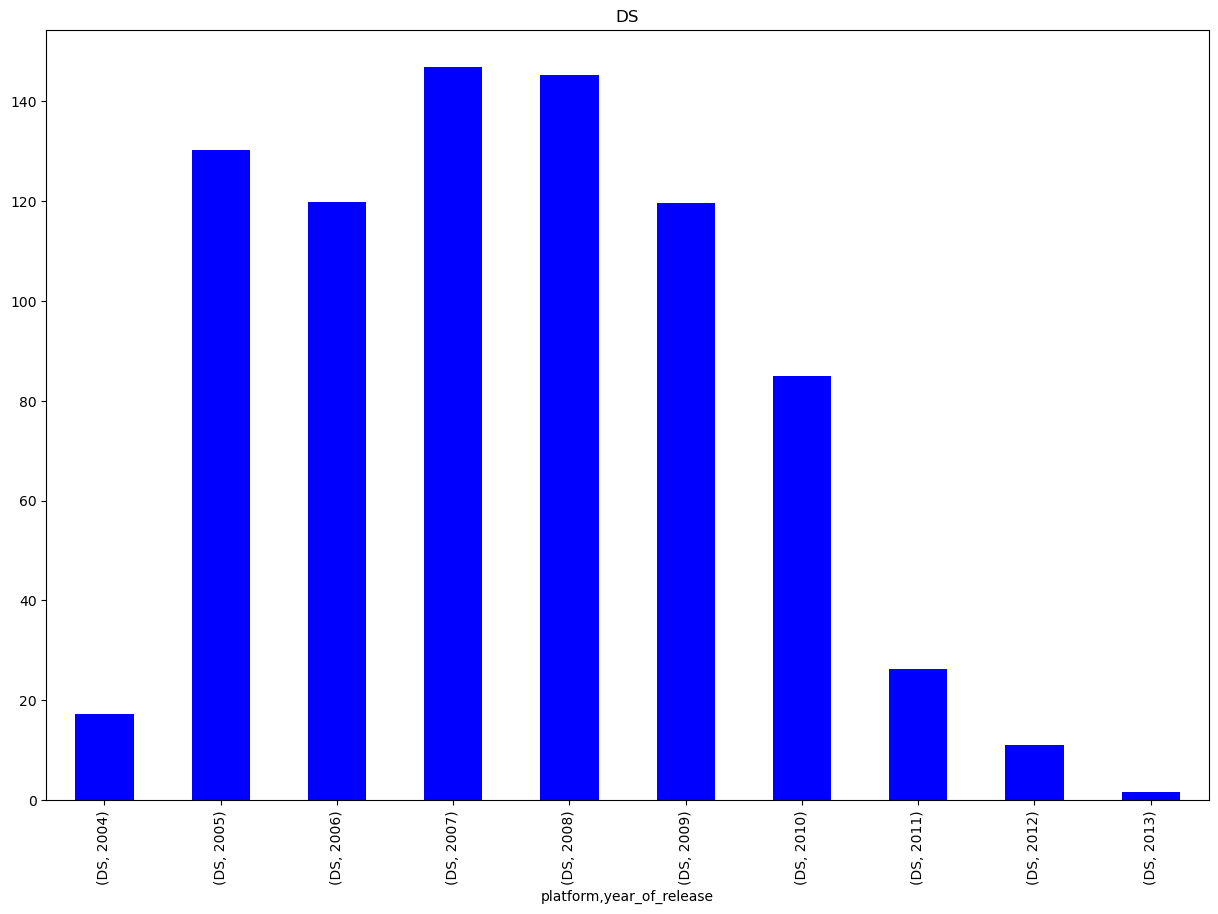

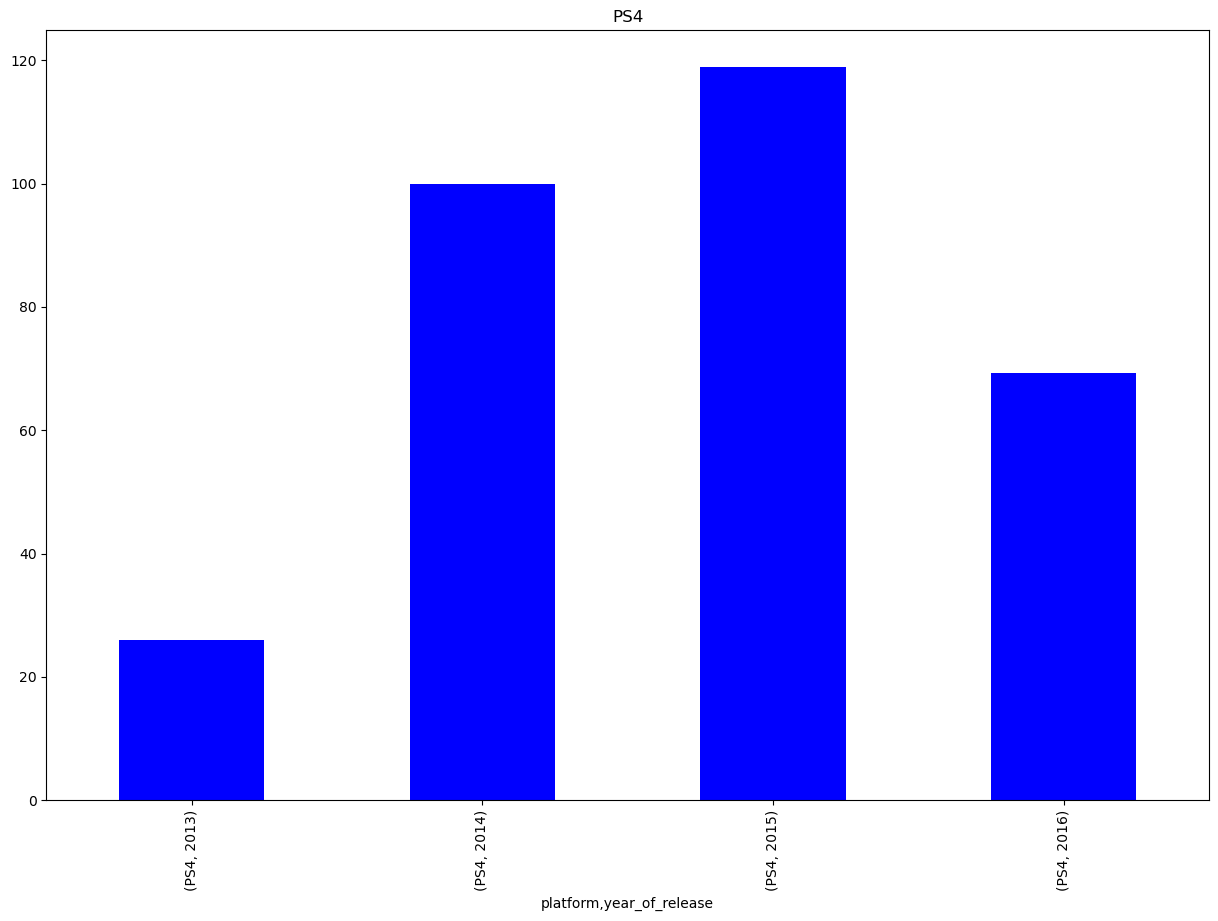

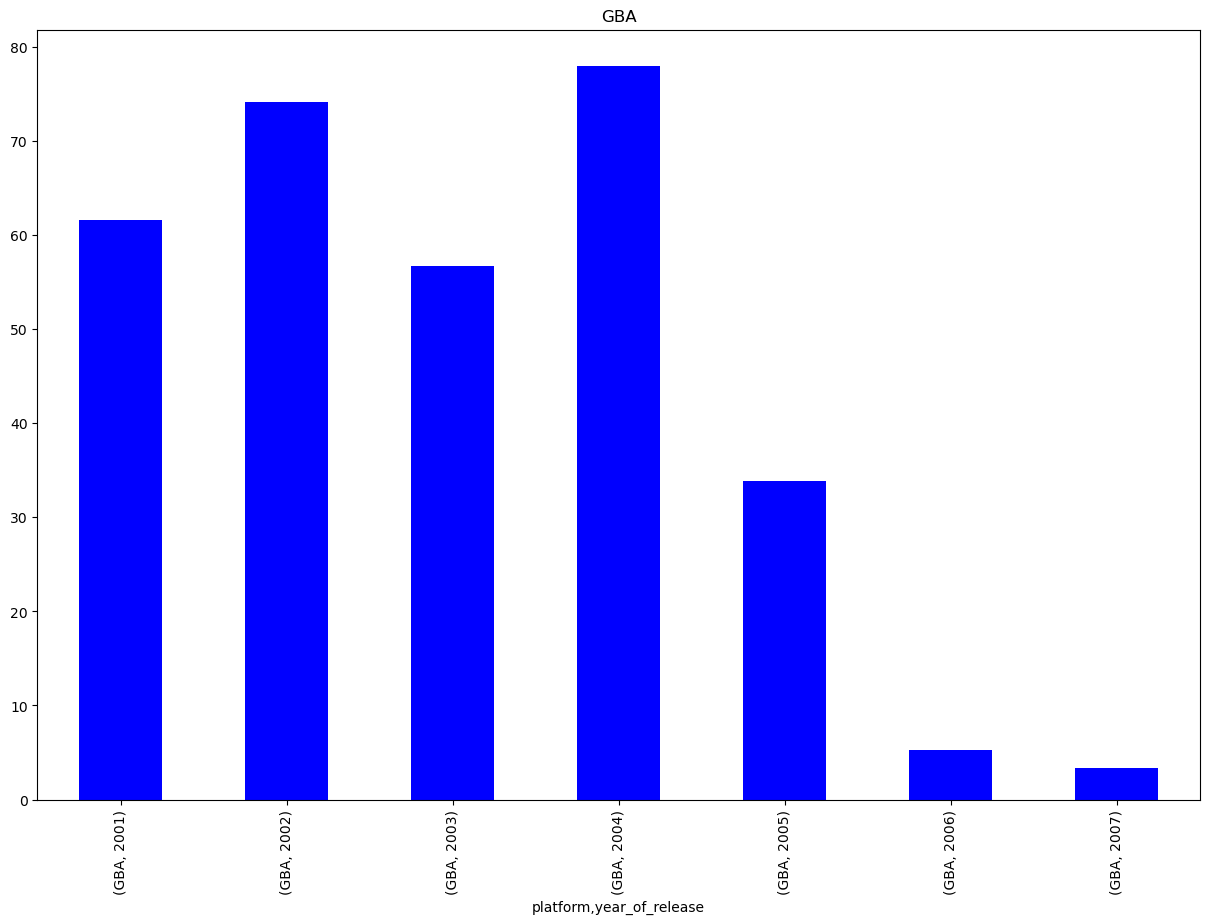

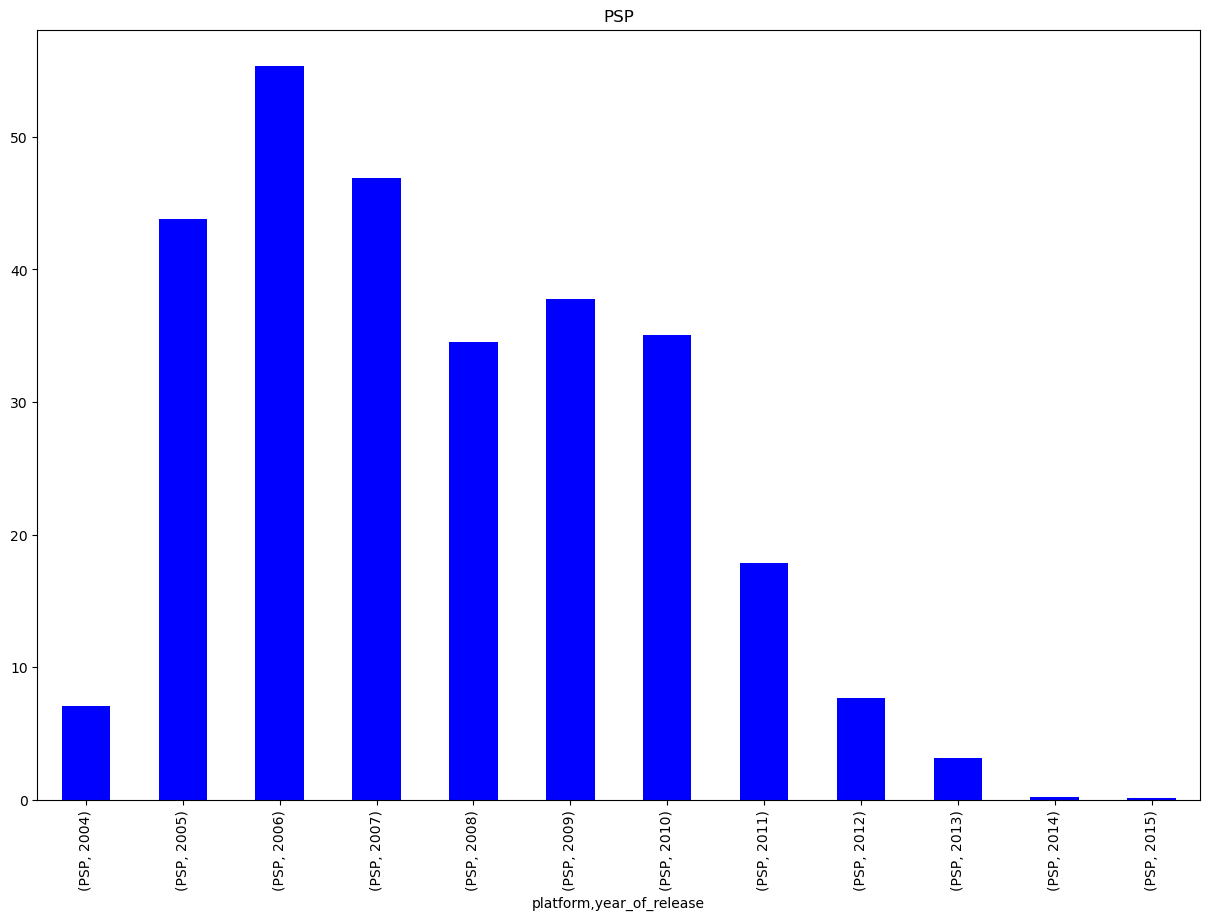

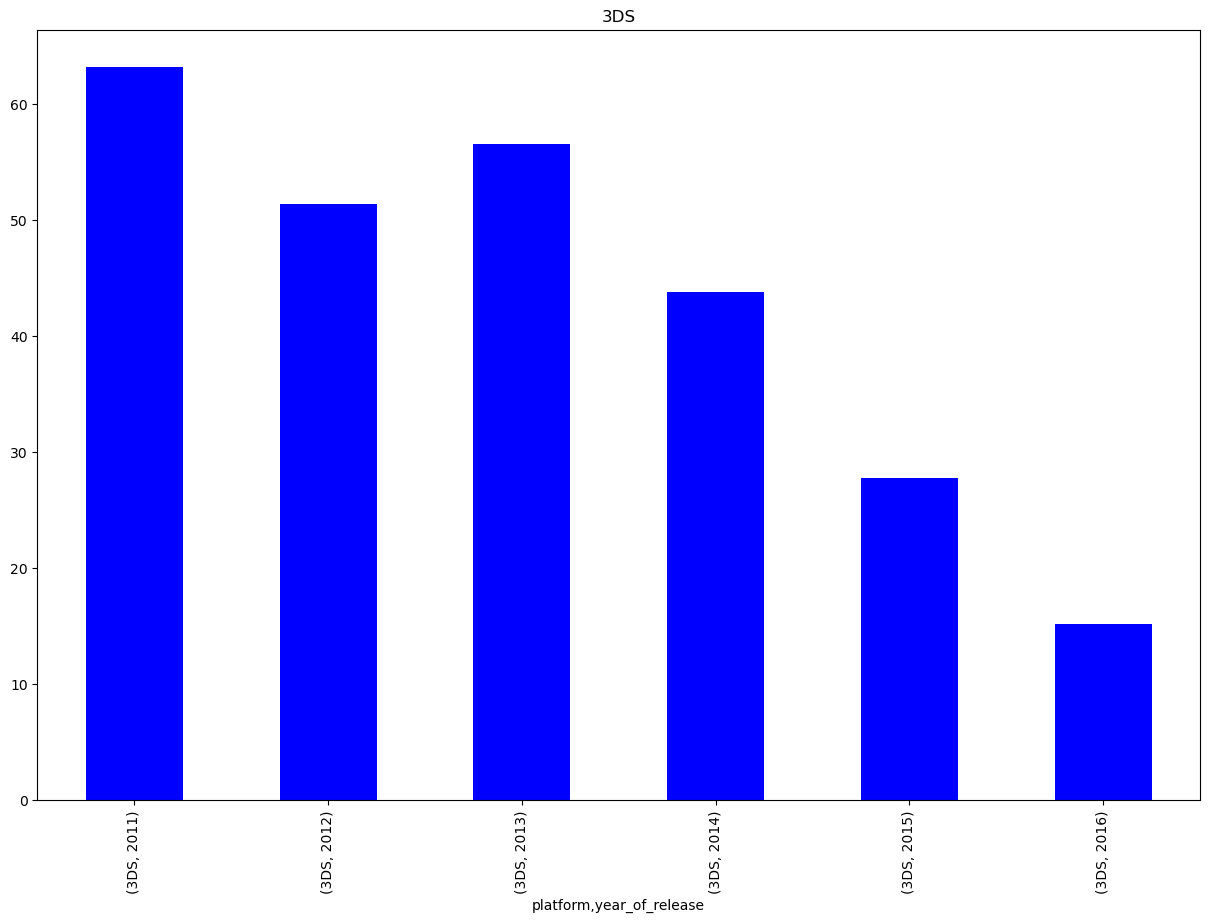

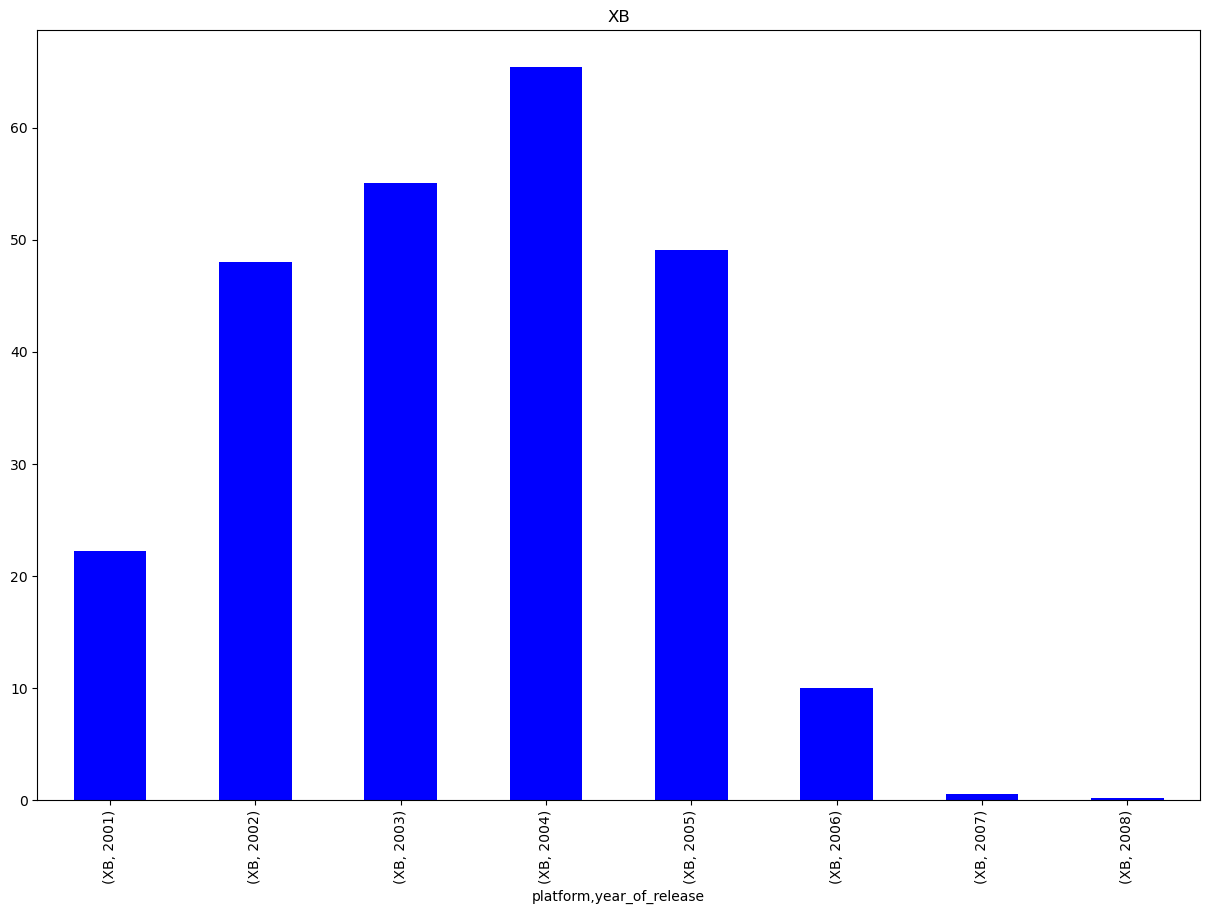

In [25]:
for i in top_10.index.tolist():
    data.loc[data['platform'] == i].groupby(['platform','year_of_release'])['total_sales'].sum() \
    .plot(kind='bar',color = 'blue', figsize = (15,10), title = i)
    plt.show()

Построив распределие по годам можем сделать несколько выводов:
* Наибольшее количество копий было проданно платформой PS2 в 2004 году;
* Характерный срок появления новых и исчезновения старых платформ - 10 лет.

Для прогнозирования рекламной компании на 2017 год, нам потребуются данные с действующими платформами. Что бы понять какие платформы имеют перспективы роста, возьмем за актуальный период данные с 2013 по 2016 годы. Периоды за предыдущие периоды не берем так сможем понять какие именно платформы будут расти дальше, что видно на графике с распределением продаж по годам.

* Возьмем за актуальный период продажи с 2013 по 2016 годы.

In [26]:
data = data.loc[data['year_of_release']>=2013 ]

In [27]:
current_platforms = data.groupby(['platform'])['total_sales'].sum()
current_platforms.sort_values(ascending=False)

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
Name: total_sales, dtype: float64

In [28]:
print('Исследуемые платформы:',current_platforms.index.tolist())

Исследуемые платформы: ['3DS', 'DS', 'PC', 'PS3', 'PS4', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']


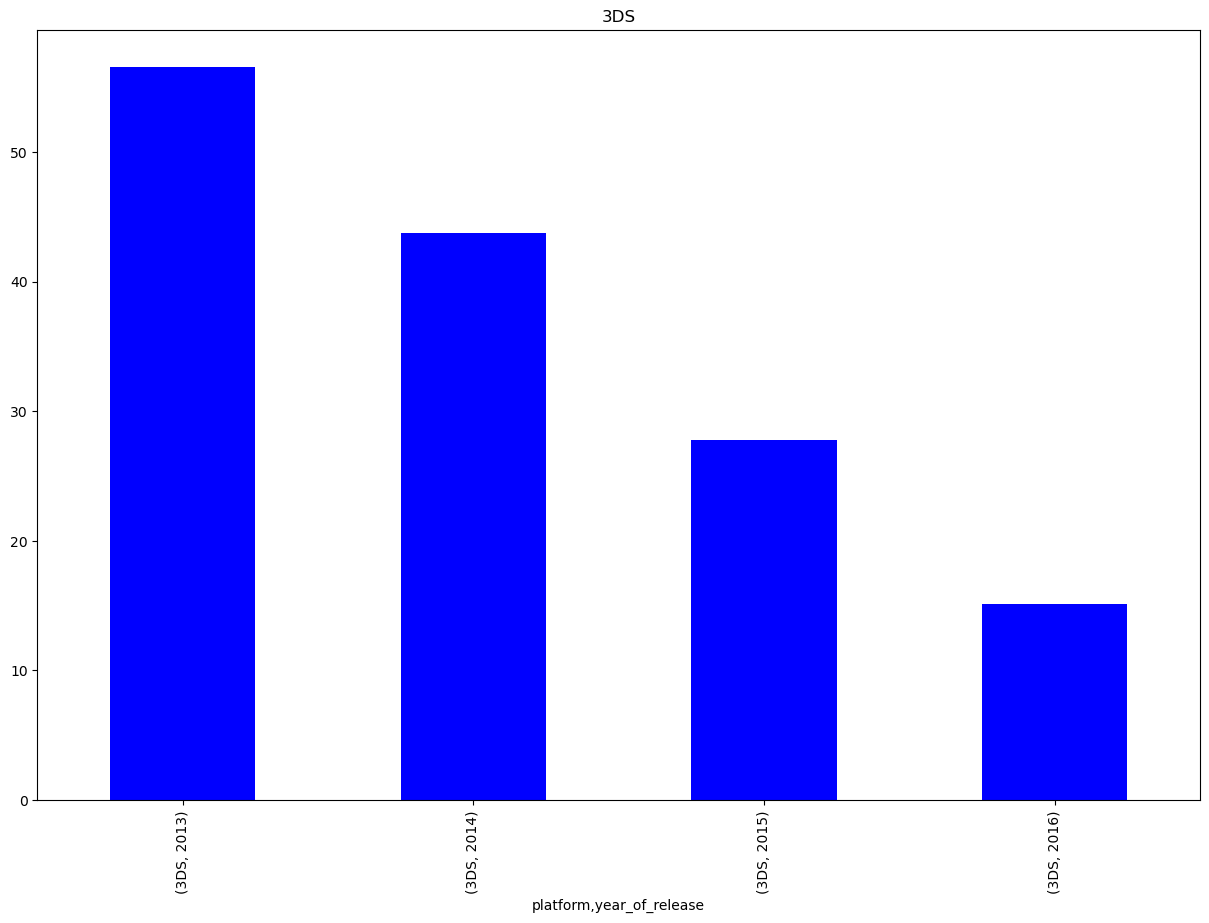

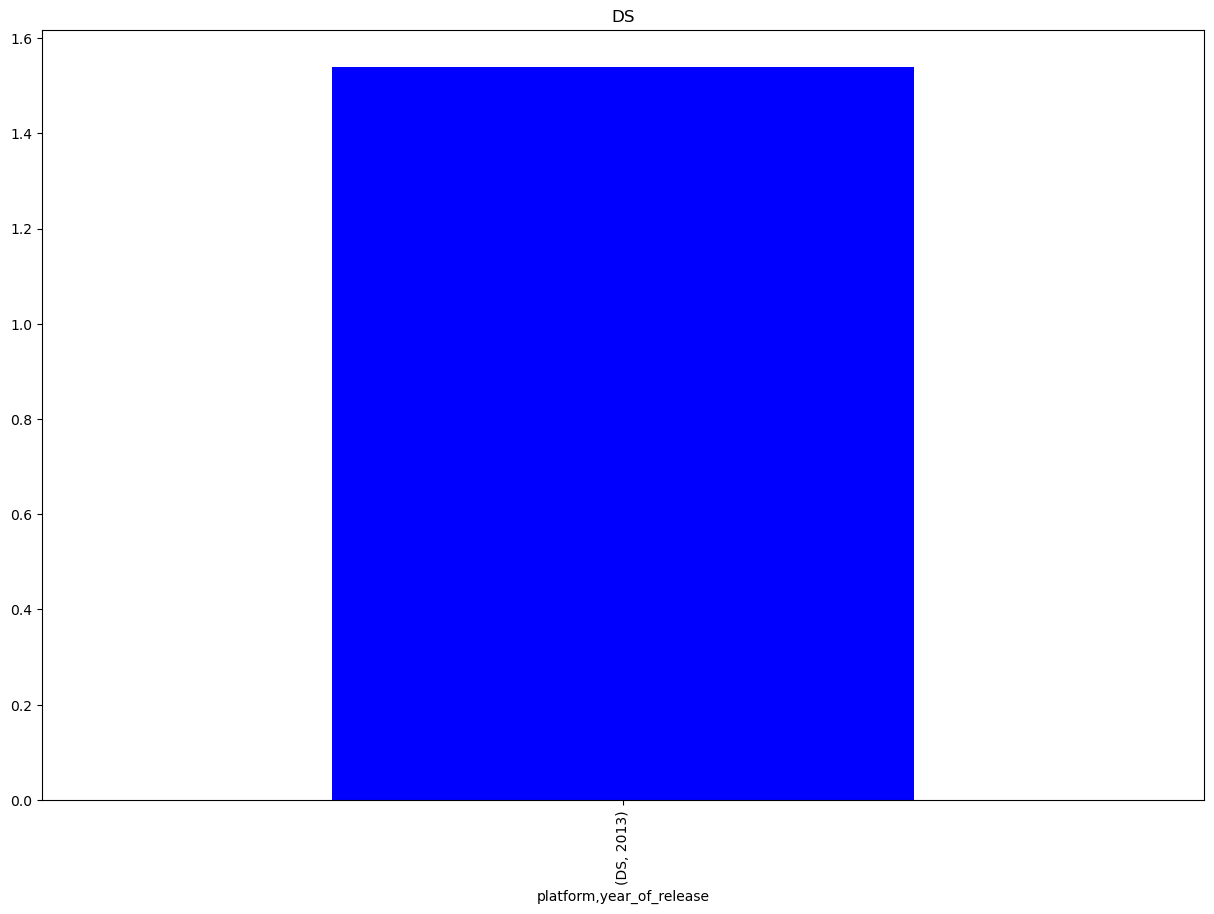

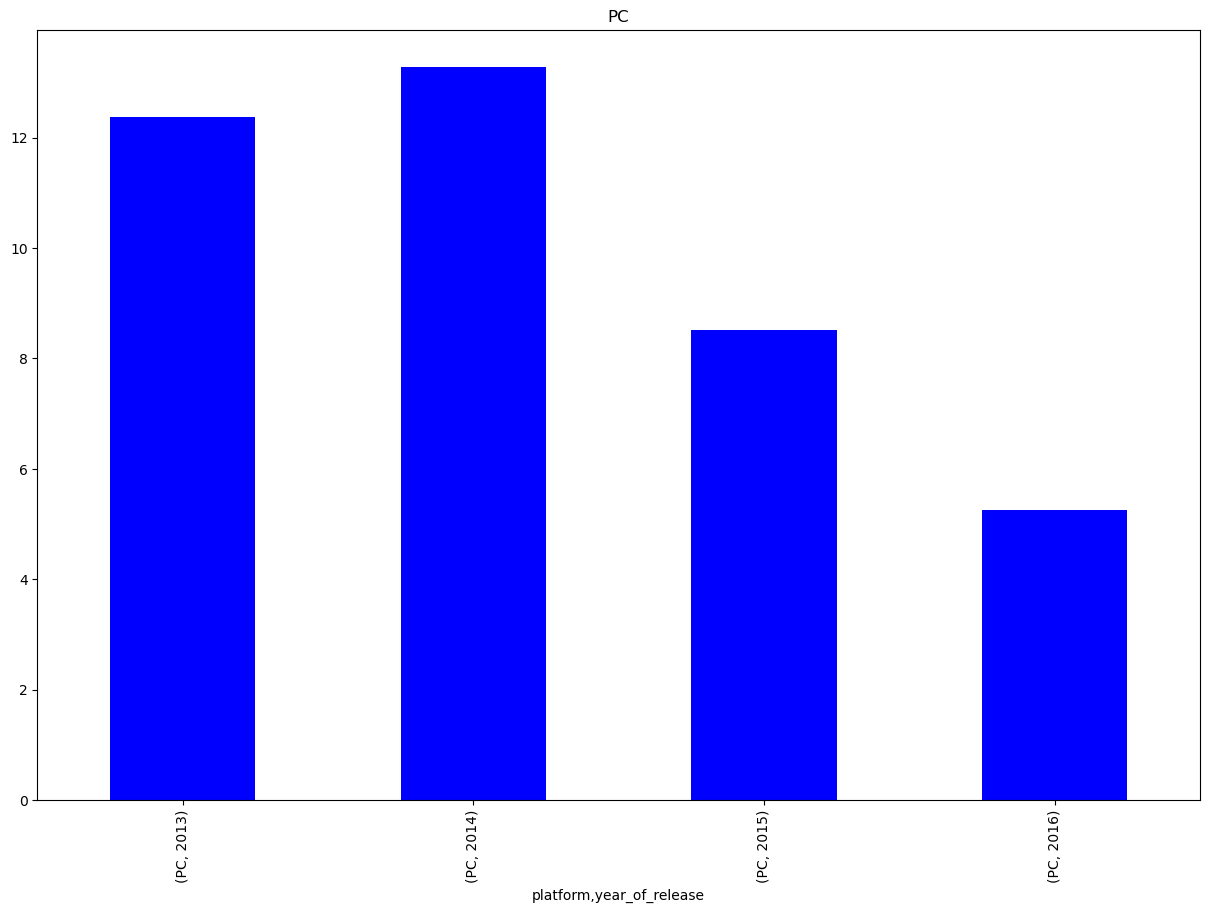

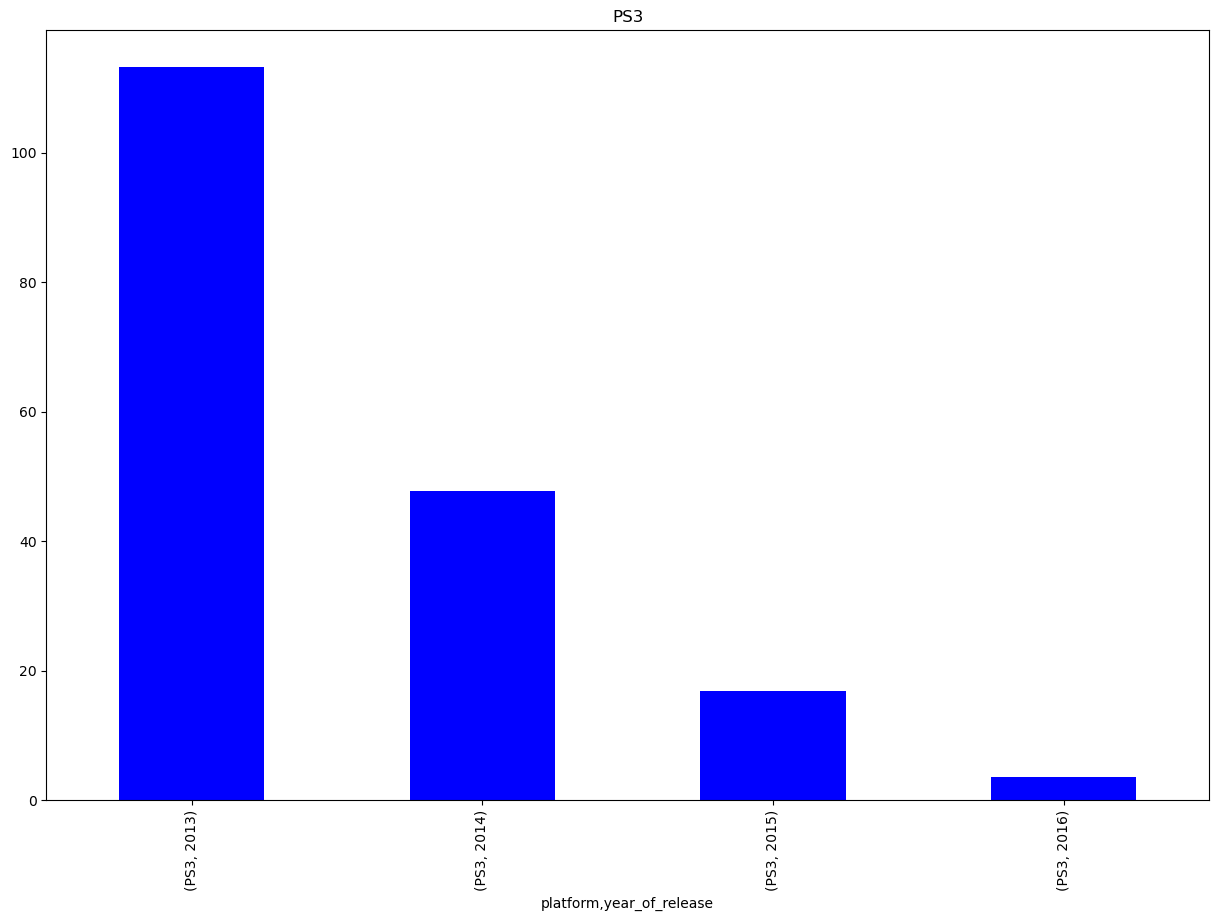

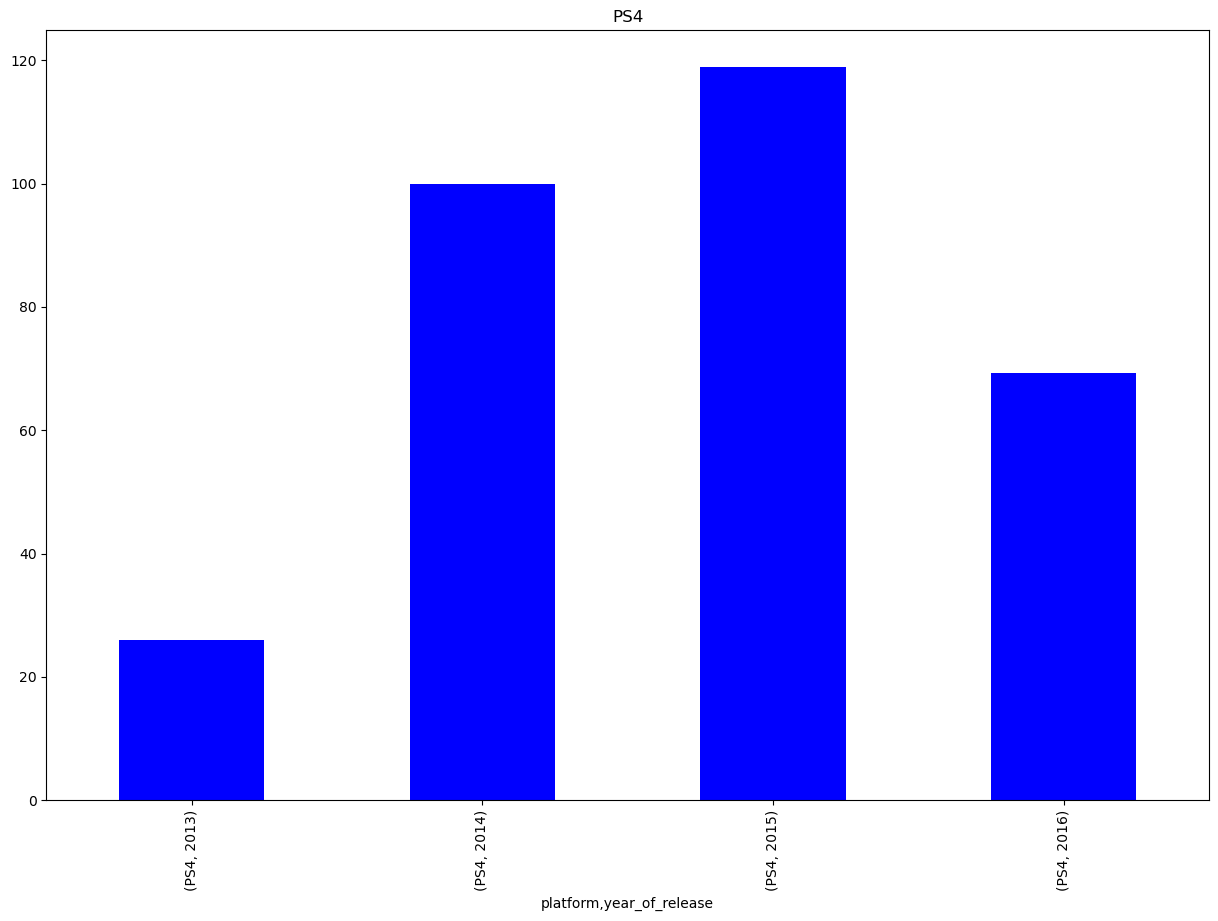

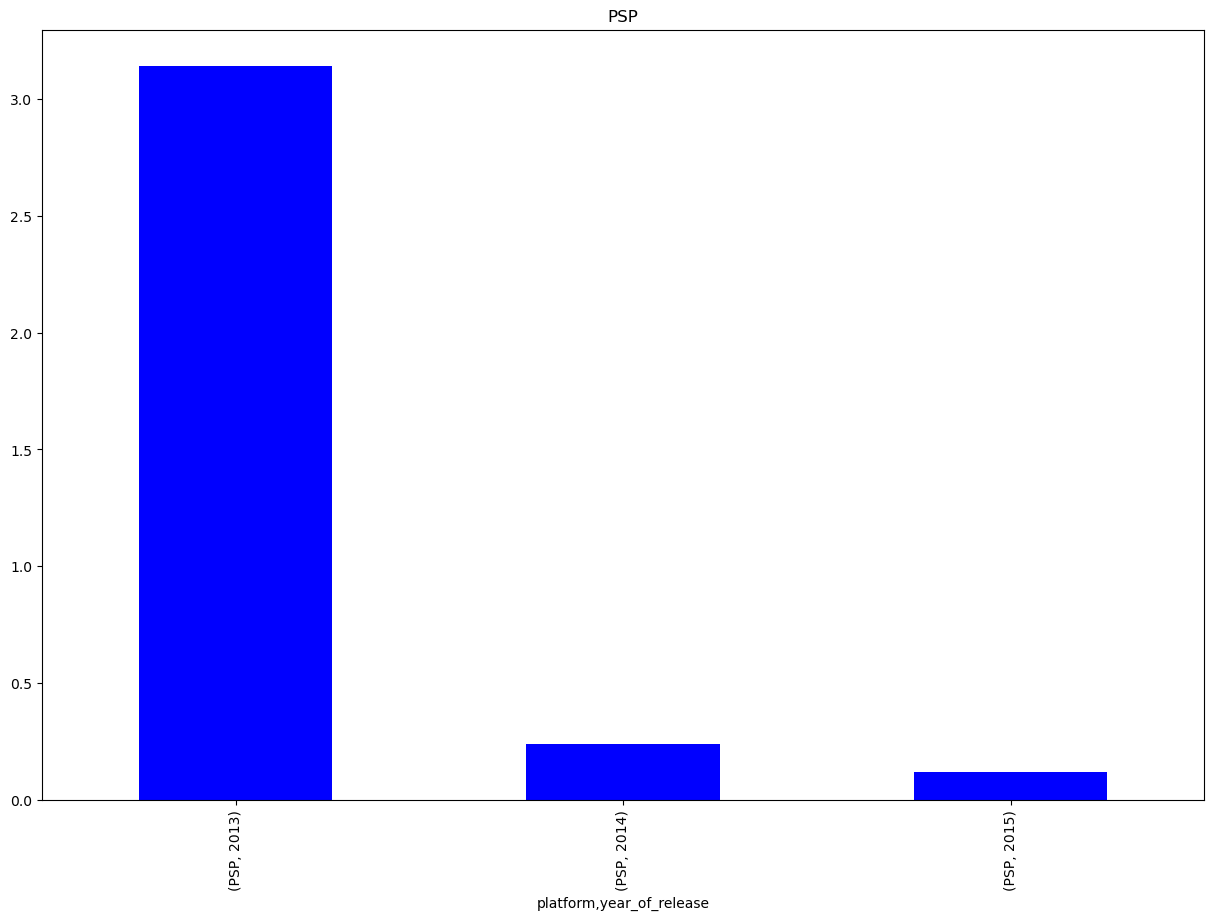

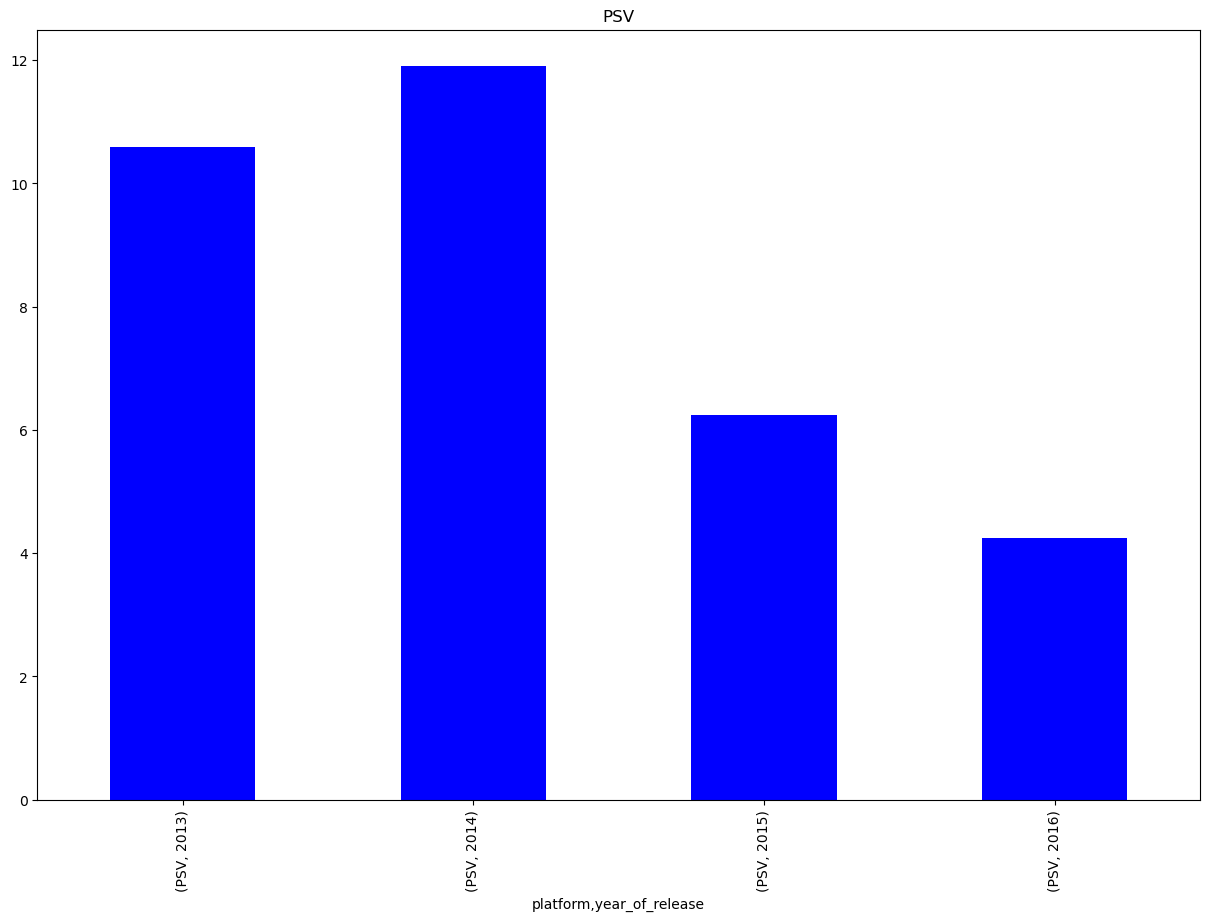

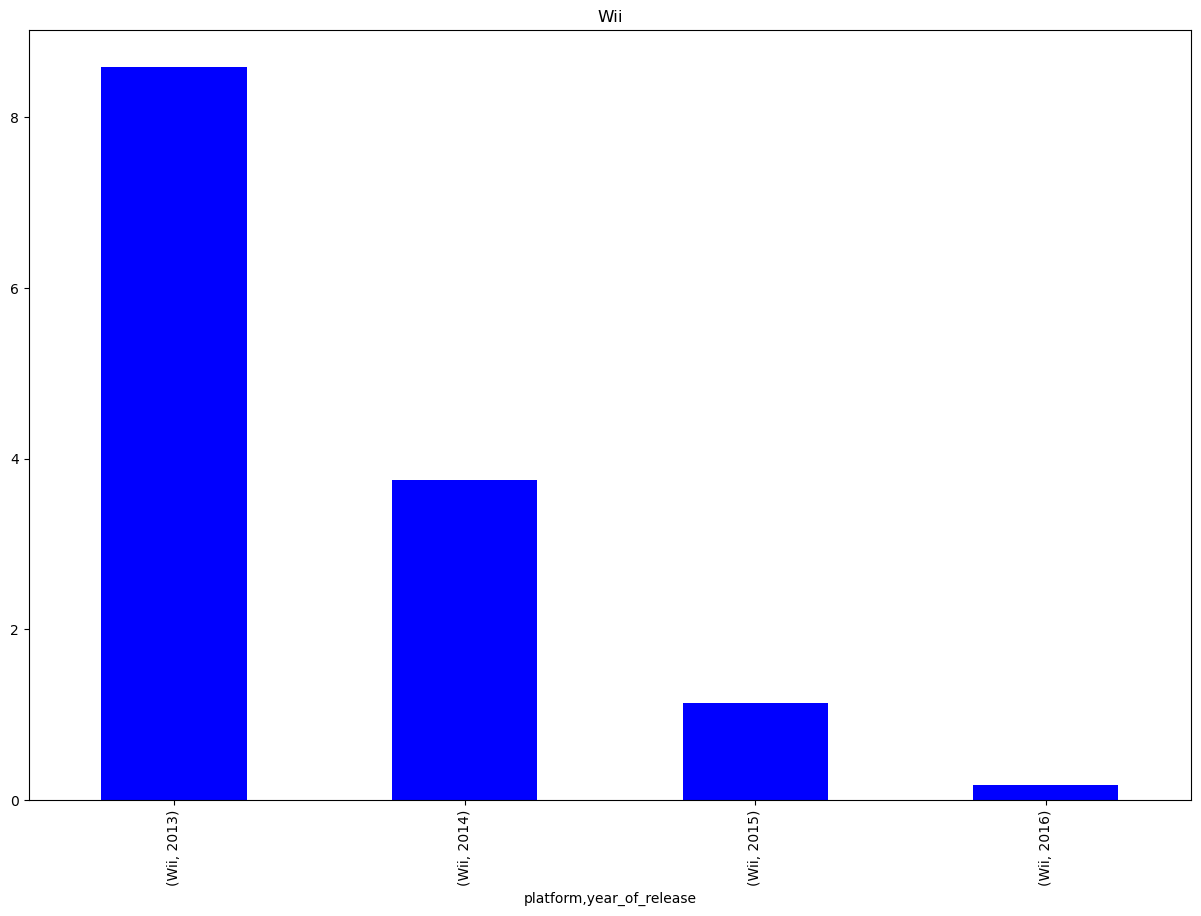

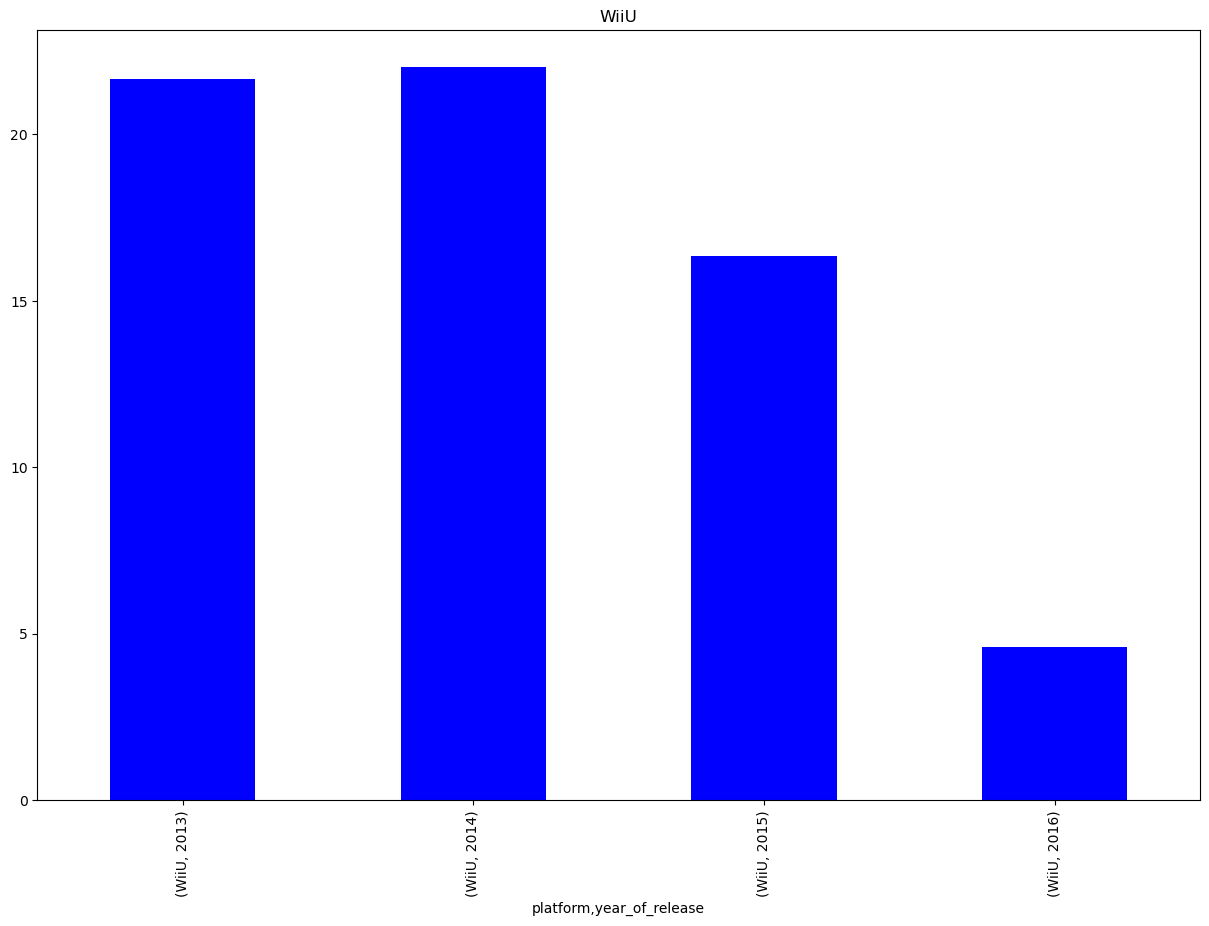

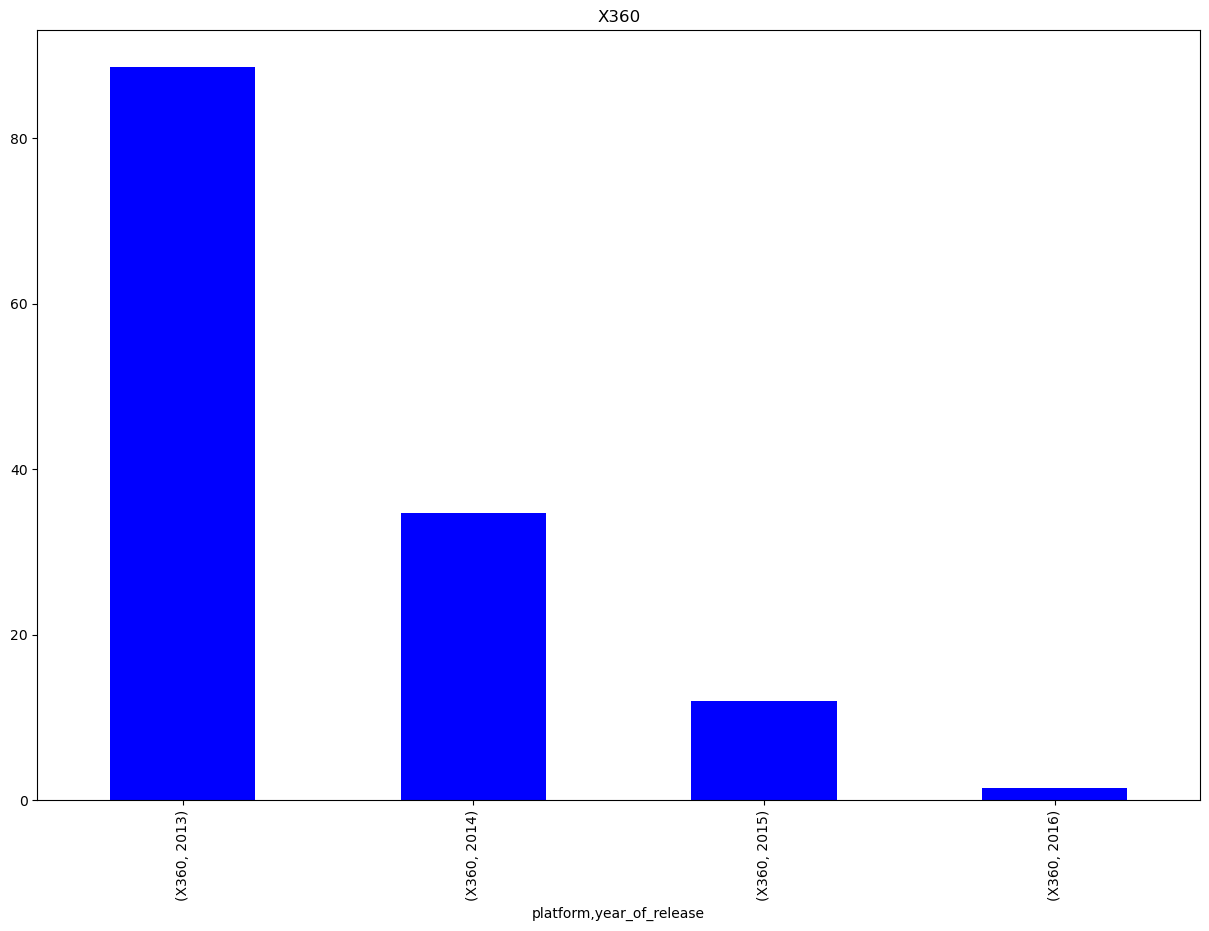

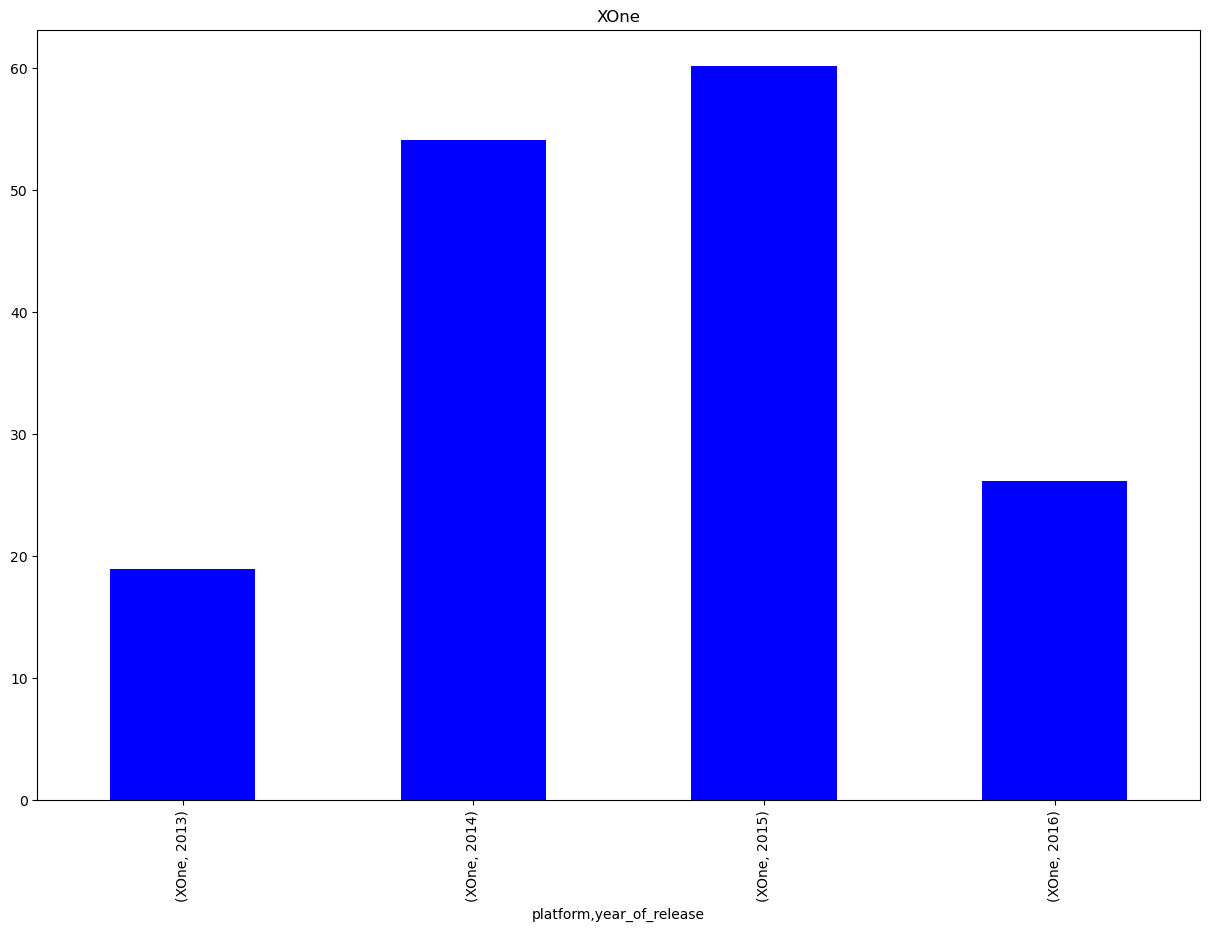

In [29]:
for i in current_platforms.index.tolist():
    data.loc[data['platform'] == i].groupby(['platform','year_of_release'])['total_sales'].sum() \
    .plot(kind='bar',color = 'blue', figsize = (15,10), title = i)
    plt.show()

Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ. Для этого построим график продаж за 2015 год по действующим платформам.

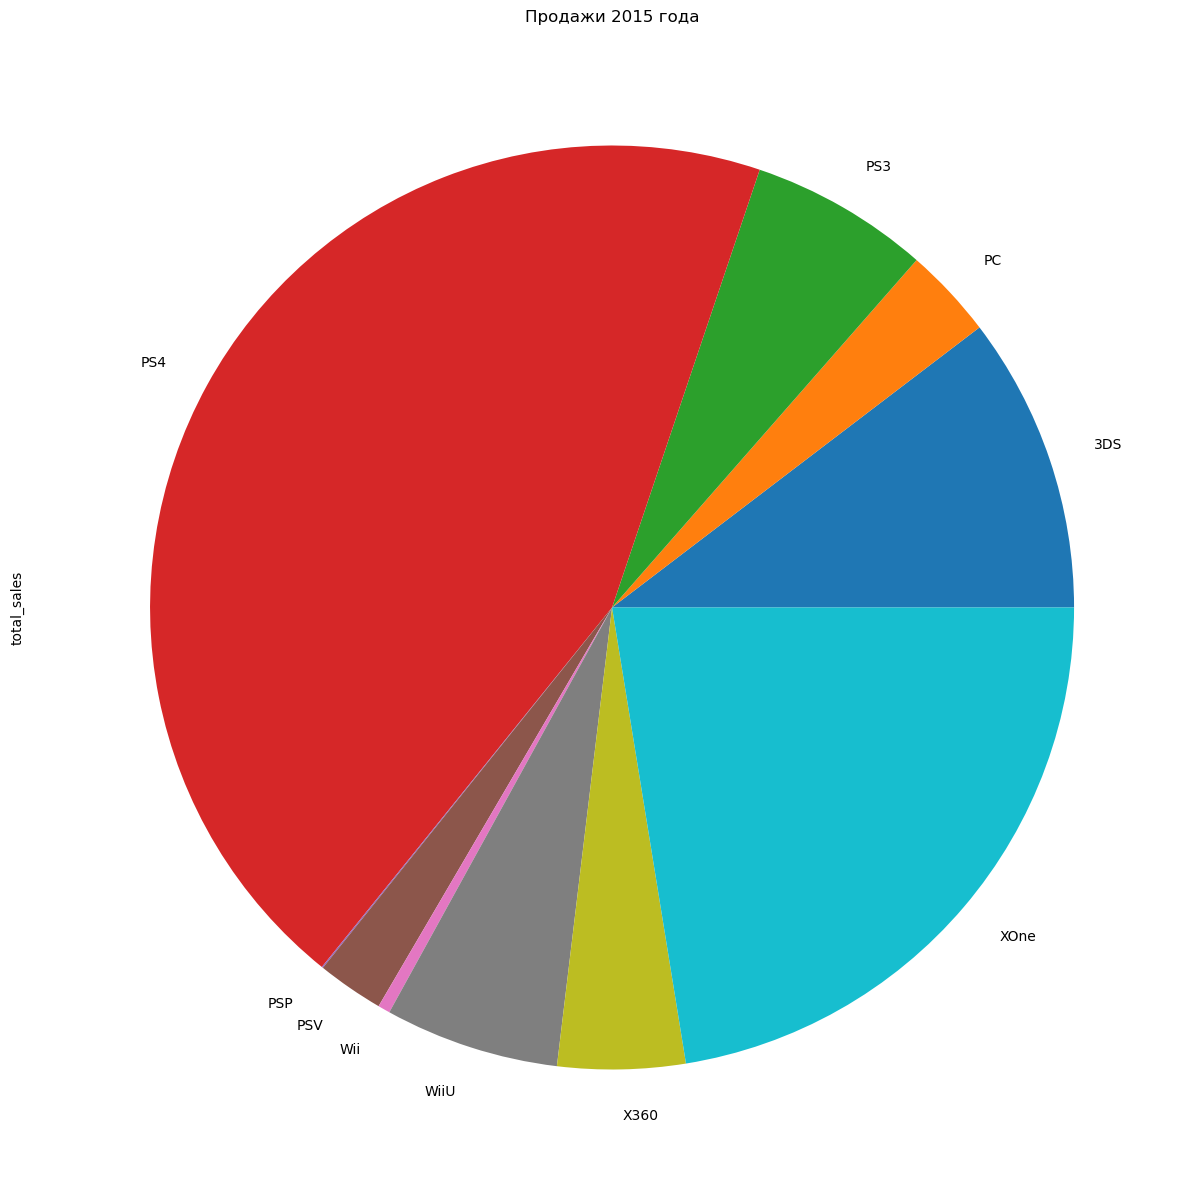

In [30]:
data.loc[data['year_of_release'] == 2015].groupby('platform')['total_sales'].sum() \
.plot(kind='pie', figsize=(15,15),title='Продажи 2015 года')
plt.show()

Потенциально прибыльные платформы:
* PS4. Лидер продаж 2015 года данная платформа на момент анализа достаточно молода и у нее еще все впереди, так же на гистограмме видно что продажи за выбранный период растут;
* XOne. Почти четверть продаж в 2015 году пришлось на эту модель. Хоть и она не попала в предыдущий рейтинг, является потенциально прибыльной, так же на гистограмме видно что продажи за выбранный период растут;
* 3DS. Еще минимум 3 года будет существовать, продажи на высоком уровне. Выпускают достаточно много игр.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по потенциально прибыльным платформам.

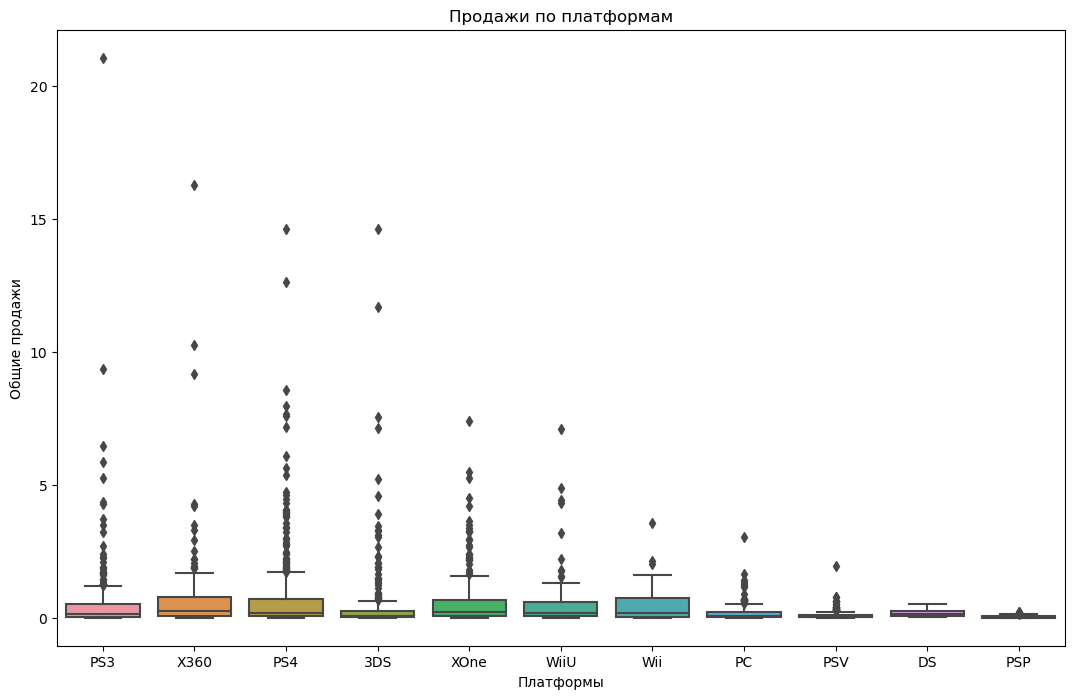

In [31]:
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data, y = 'total_sales', x='platform')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи'))

plt.show()

Присмотримся к "ящикам" повнимательнее, ограничим общие продажи 2,5:

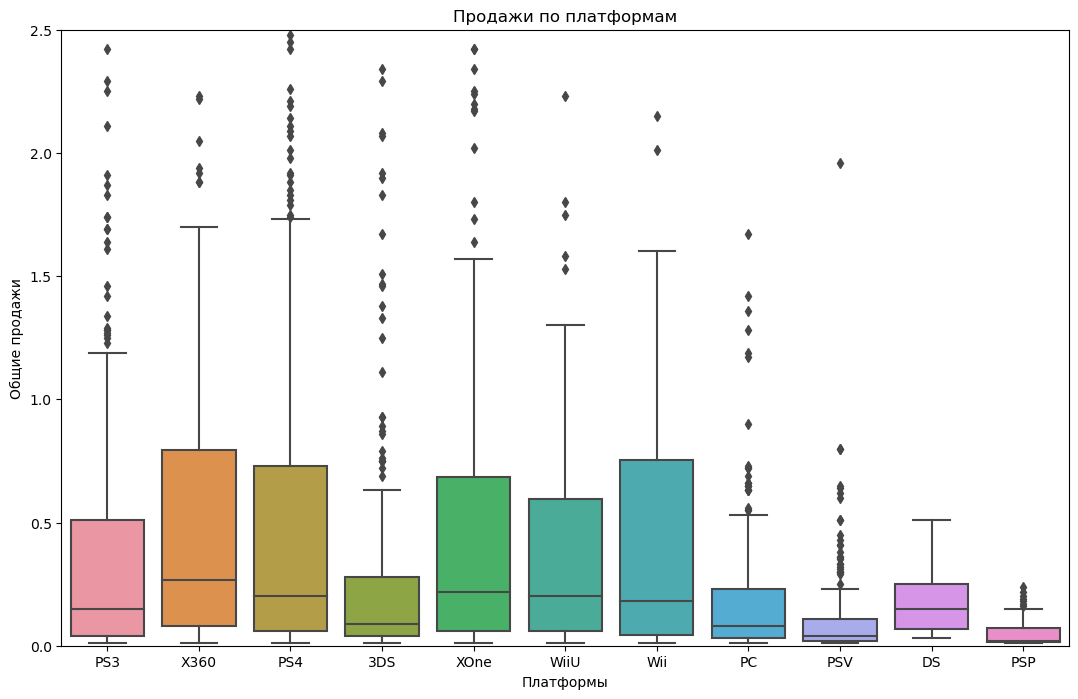

In [32]:
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data, y = 'total_sales', x='platform')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 2.5)))

plt.show()

На графике видно что у всех платформ медиана ближе к первому квартилю, это значит что большая часть данных имеет низкое значение. Следовательно преобладают платформы, у которых, много игр с небольшими продажами и небольшим числом мегапопулярных игр!

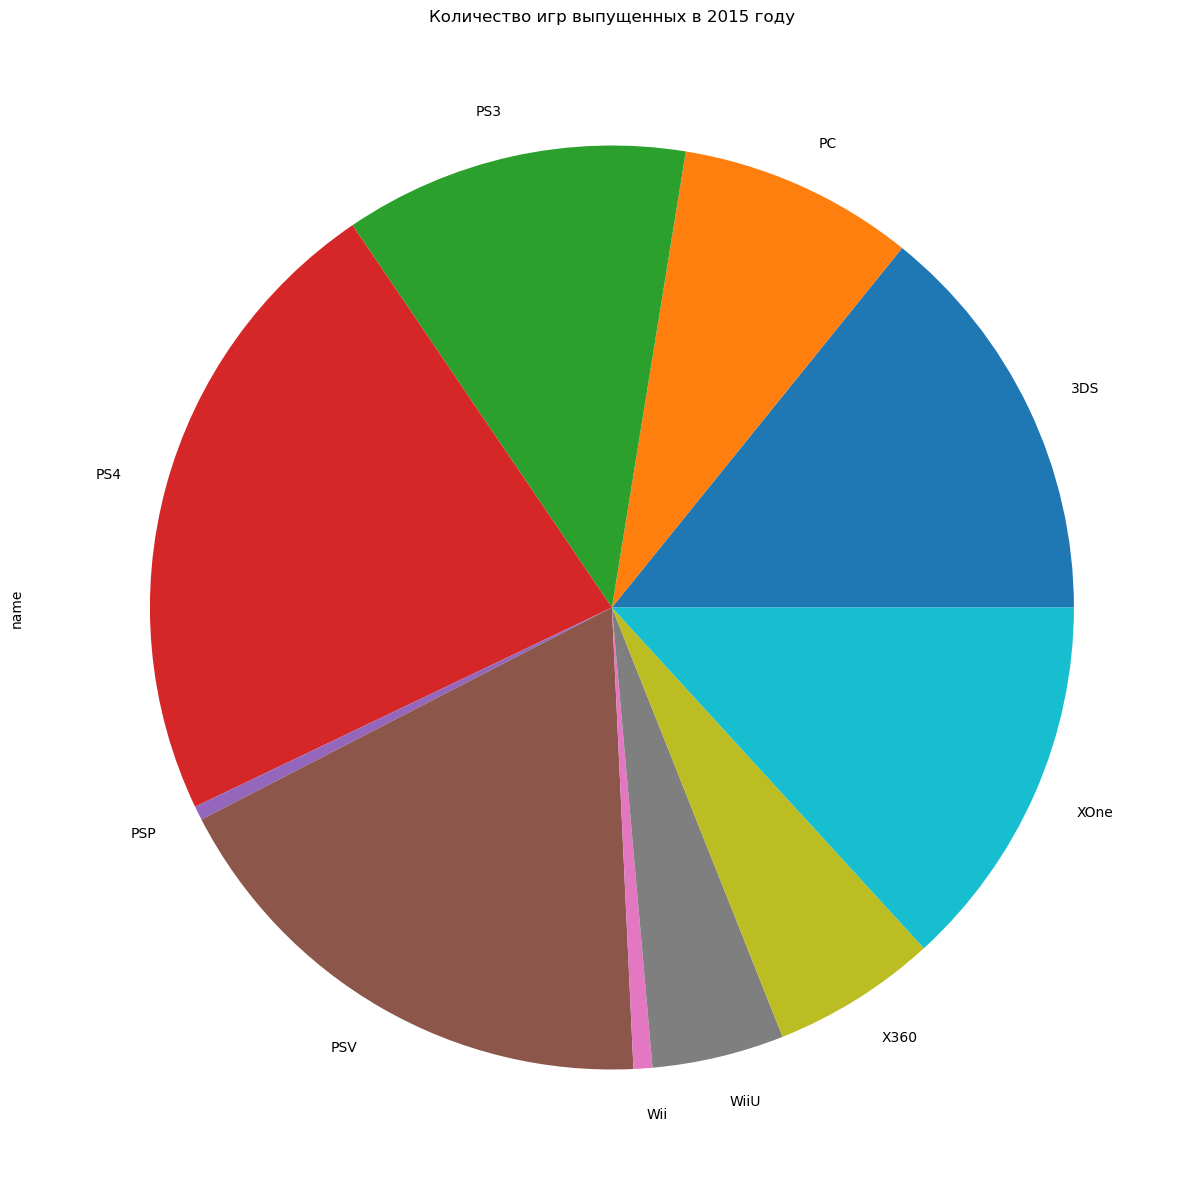

In [33]:
data.loc[data['year_of_release'] == 2015].groupby('platform')['name'].count() \
.plot(kind='pie', figsize=(15,15),title='Количество игр выпущенных в 2015 году')
plt.show()

Посмотрим, как влияют на продажи платформы 'PS4' отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

* На продажи практически не влияет оценка пользователей;
* Продажи слабо зависят от оценки критиков;
* Так же можем сделать вывод что есть положительная зависимость между оценкой критиков и оценкой пользователей.

In [34]:
def dependence(platform):
    df = data.loc[data['platform'] == platform]
    for i in ['critic_score','user_score']:
        df.plot(x='total_sales', y=i, kind='scatter', alpha=0.8, figsize =(12,7)) 
        plt.show()
        display(df[['total_sales', i]].corr())
    display(df[['critic_score','user_score']].corr())

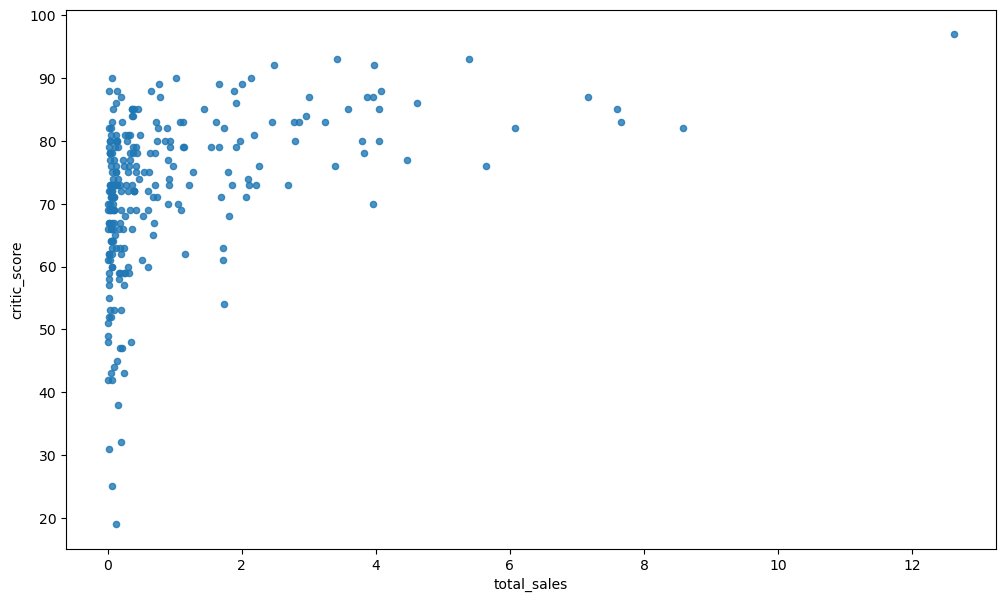

,total_sales,critic_score
total_sales,1.000000,0.406568
critic_score,0.406568,1.000000


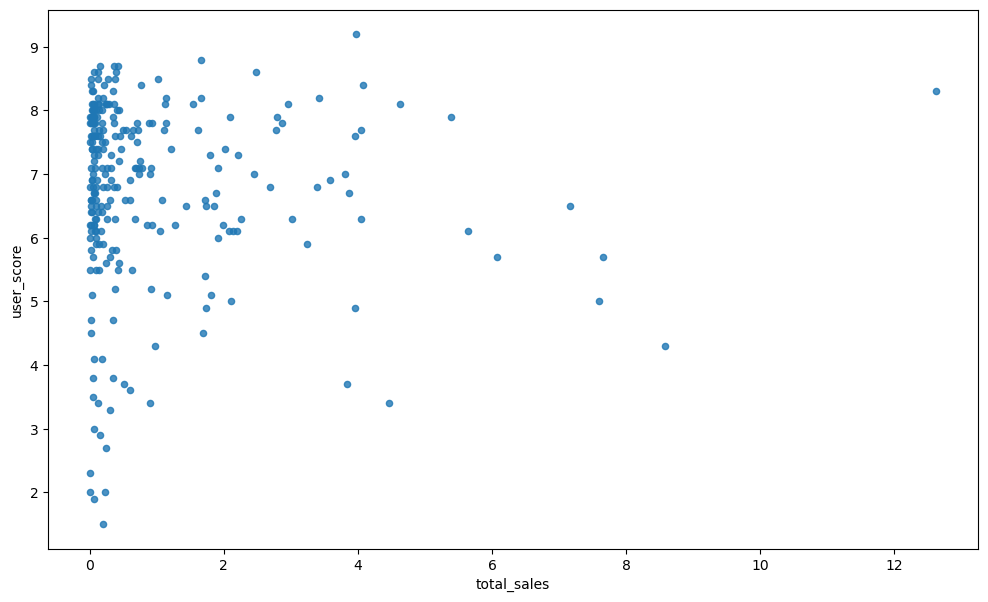

,total_sales,user_score
total_sales,1.000000,-0.031957
user_score,-0.031957,1.000000


,critic_score,user_score
critic_score,1.000000,0.557654
user_score,0.557654,1.000000


In [35]:
dependence('PS4')

* На продажи практически не влияет оценка пользователей;
* Есть слабая линейная зависимость продаж от оценки критиков;
* Так же можем сделать вывод что есть положительная линейная зависимость между оценкой критиков и оценкой пользователей.

Корреляция с отзывами критиков выше, так как они оценивают игру раньше и уже после этого игра поступает в продажу.

Проверим эти утверждения еще на пяти других платформах:

'Платформа:'

'PSV'

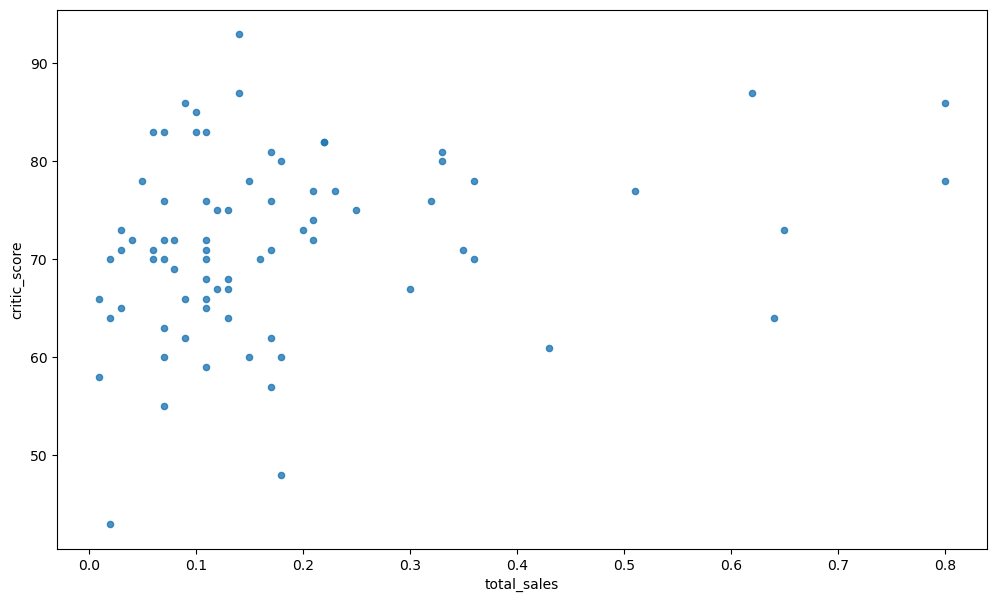

,total_sales,critic_score
total_sales,1.000000,0.254742
critic_score,0.254742,1.000000


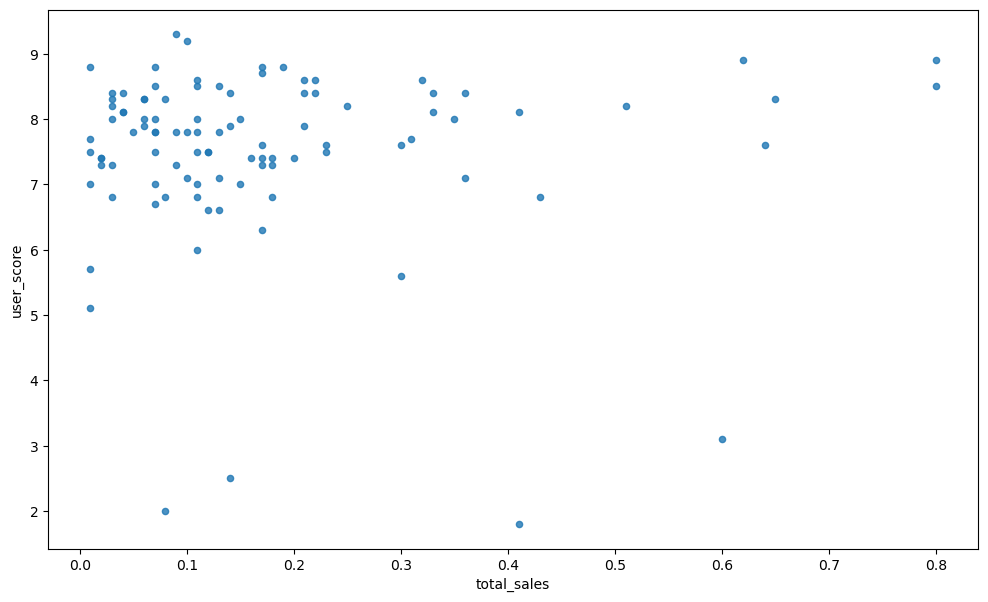

,total_sales,user_score
total_sales,1.000000,0.000942
user_score,0.000942,1.000000


,critic_score,user_score
critic_score,1.000000,0.611521
user_score,0.611521,1.000000


'Платформа:'

'PC'

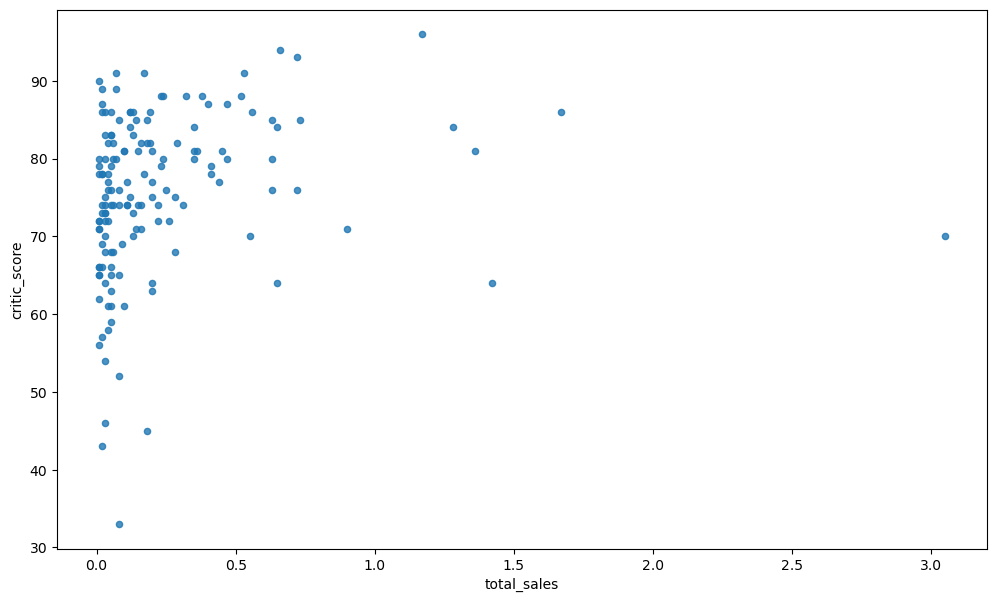

,total_sales,critic_score
total_sales,1.00000,0.19603
critic_score,0.19603,1.00000


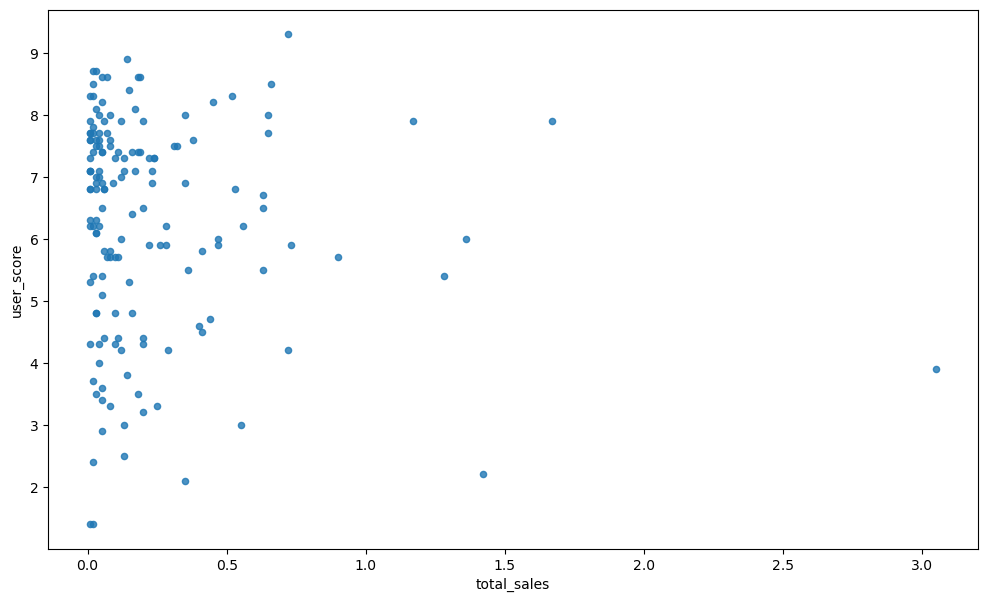

,total_sales,user_score
total_sales,1.000000,-0.093842
user_score,-0.093842,1.000000


,critic_score,user_score
critic_score,1.000000,0.429562
user_score,0.429562,1.000000


'Платформа:'

'WiiU'

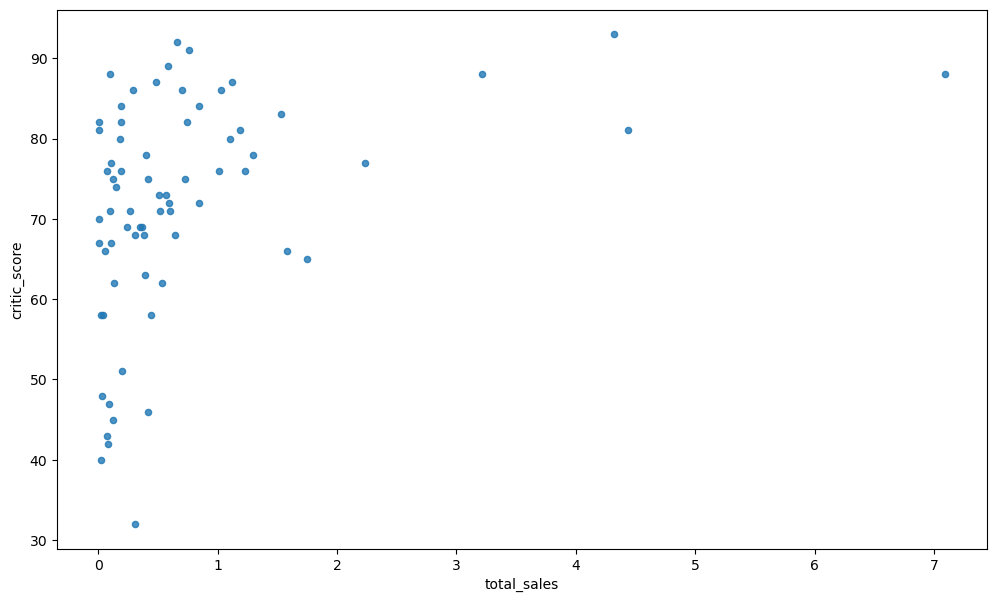

,total_sales,critic_score
total_sales,1.000000,0.376415
critic_score,0.376415,1.000000


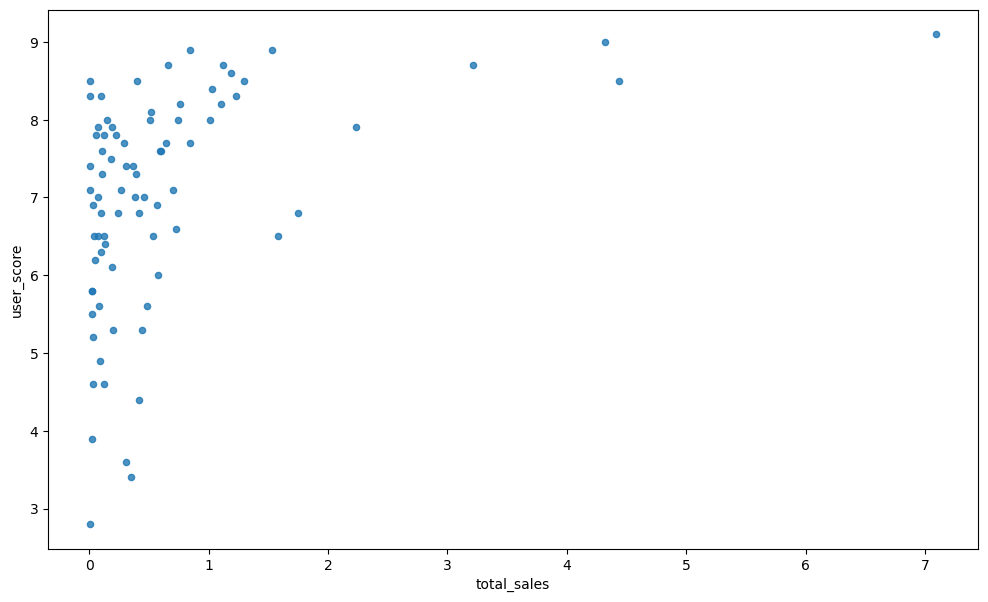

,total_sales,user_score
total_sales,1.00000,0.41933
user_score,0.41933,1.00000


,critic_score,user_score
critic_score,1.000000,0.721313
user_score,0.721313,1.000000


'Платформа:'

'X360'

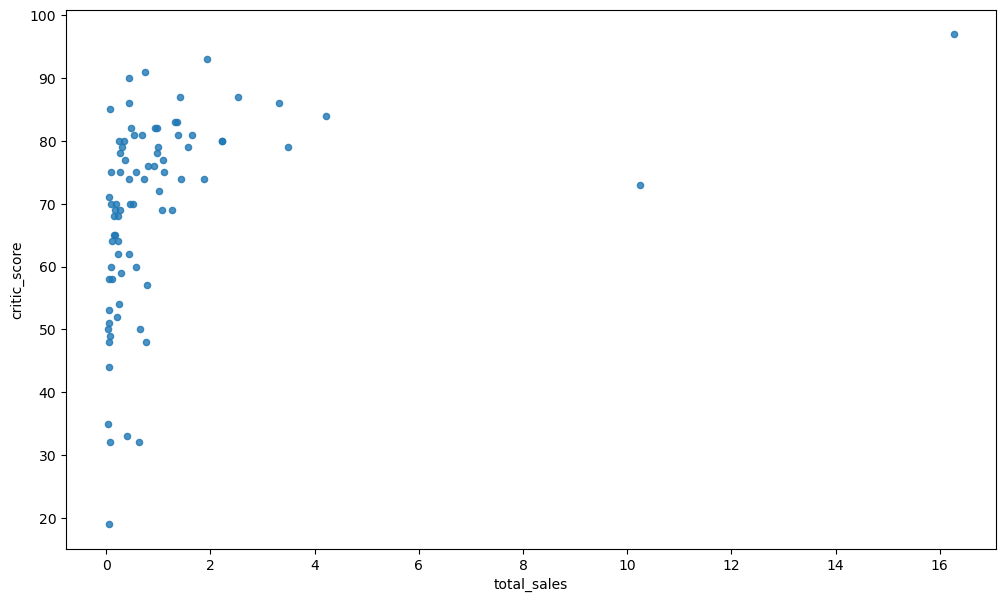

,total_sales,critic_score
total_sales,1.000000,0.350345
critic_score,0.350345,1.000000


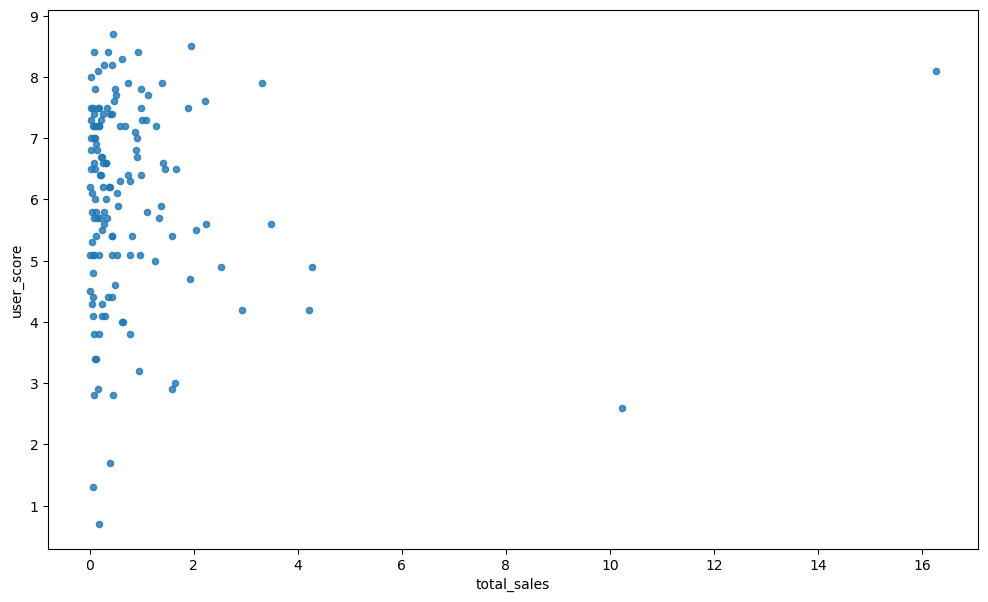

,total_sales,user_score
total_sales,1.000000,-0.011742
user_score,-0.011742,1.000000


,critic_score,user_score
critic_score,1.000000,0.520946
user_score,0.520946,1.000000


'Платформа:'

'XOne'

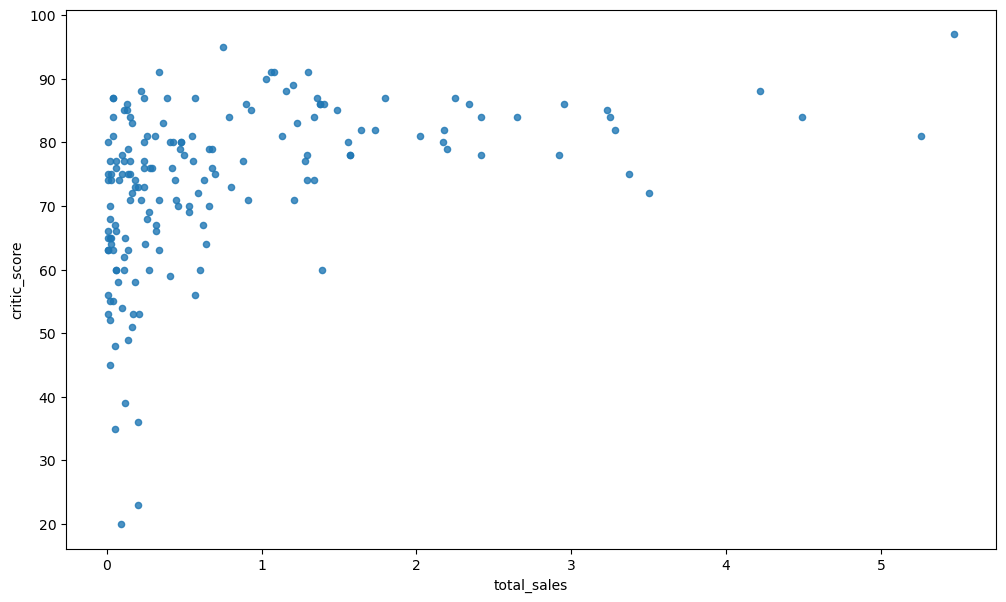

,total_sales,critic_score
total_sales,1.000000,0.416998
critic_score,0.416998,1.000000


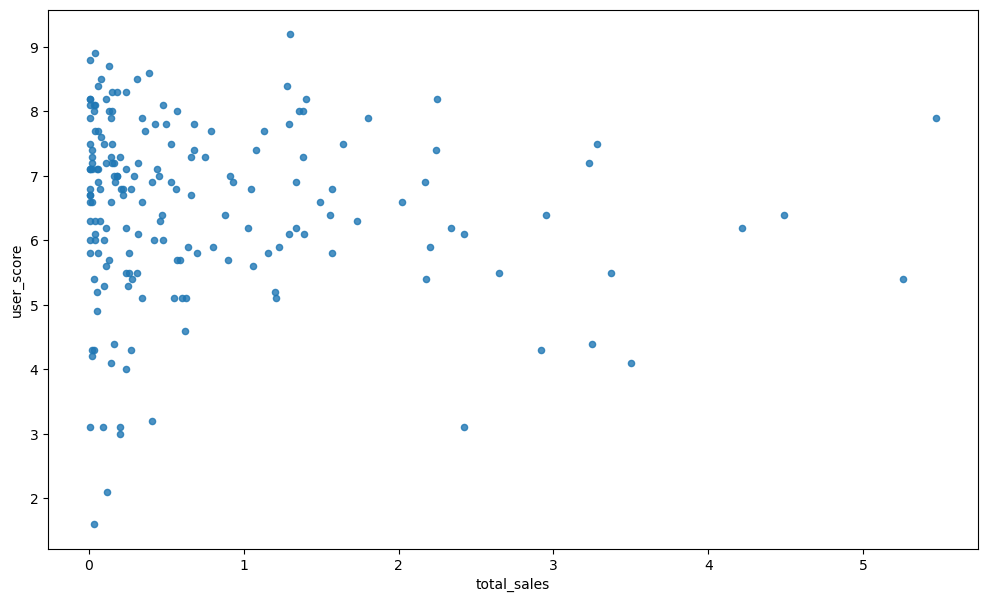

,total_sales,user_score
total_sales,1.000000,-0.068925
user_score,-0.068925,1.000000


,critic_score,user_score
critic_score,1.000000,0.472462
user_score,0.472462,1.000000


In [36]:
for i in ['PSV', 'PC', 'WiiU', 'X360', 'XOne']:
    display('Платформа:', i)
    dependence(i)

В полученных данных видим, что:
* По большему количеству платформ, что выводы полученные по данным PS4 совпадают;
* Но для платформы 'WiiU' положительная линейная зависимость продаж от оценки пользователей выше чем от оценки критиков;
* А для платформы 'PC', есть отрицательная линейная зависимость от оценки пользователей.

**Можем сделать предварительный вывод, что:**
* Есть положительная линейная зависимость продаж от оценки критиков;
* Есть положительная линейная зависимость между оценкой критиков и оценкой пользователей.

Посмотрим на общее распределение игр по жанрам, для этого возьмем среднее суммарных продаж в жанре:

In [37]:
data.groupby(['genre'])['total_sales'].mean().sort_values(ascending = False)

genre
Shooter         1.245882
Sports          0.703972
Platform        0.576081
Role-Playing    0.499623
Racing          0.469294
Fighting        0.441375
Action          0.420196
Misc            0.405290
Simulation      0.350968
Puzzle          0.186471
Strategy        0.180000
Adventure       0.096490
Name: total_sales, dtype: float64

* Самые популярные жанры - `Shooter`, `Sports`, `Platform`; 
* Не популярные жанры - `Strategy`, `Puzzle`, `Adventure`.

**Выводы:**
Для прогнозирования рекламной компании на 2017 год, нам потребуются данные с действующими платформами. Что бы понять какие платформы имеют перспективы роста, возьмем за актуальный период данные с 2013 по 2015 годы (2016 не учитываем, т.к. данные за текущий год могут быть не все). Периоды за предыдущие периоды не берем так сможем понять какие именно платформы будут расти дальше, что видно на графике с распределением продаж по годам.

* Взяли за актуальный период продажи с 2013 по 2015 годы;
* Выявлены 10 платформ с наибольшими суммарными продажами: ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS4', 'GBA', 'PSP', '3DS', 'XB'];
* Наибольшее количество копий игр было проданно платформой PS2 в 2004 году;
* Характерный срок появления новых и исчезновения старых платформ - 10 лет;
* Есть положительная линейная зависимость продаж от оценки критиков;
* Есть положительная линейная зависимость между оценкой критиков и оценкой пользователей;
* Преобладают платформы, у которых, много игр с небольшими продажами и небольшим числом мегапопулярных игр;
* Самые популярные жанры - `Shooter`, `Sports`, `Platform`; 
* Не популярные жанры - `Strategy`, `Puzzle`, `Adventure`.

Выявленны потенциально прибыльные платформы:
* PS4. Лидер продаж 2015 года данная платформа на момент анализа достаточно молода и у нее еще все впереди, так же на гистограмме видно что продажи за выбранный период растут;
* XOne. Почти четверть продаж в 2015 году пришлось на эту модель. Хоть и она не попала в предыдущий рейтинг, является потенциально прибыльной, так же на гистограмме видно что продажи за выбранный период растут;
* 3DS. Еще минимум 3 года будет существовать, продажи на высоком уровне. Выпускают достаточно много игр.


### Составим портрет пользователя каждого региона

**Посмотрим топ-5 платформ по продажам и жанрам в Северной Америке, Европе и Японии:**

'Пользователи Северной Америки'

platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64

top-5 platform ['PS4', 'XOne', 'X360', 'PS3', '3DS']


<AxesSubplot:title={'center':'na_sales platform'}, xlabel='platform'>

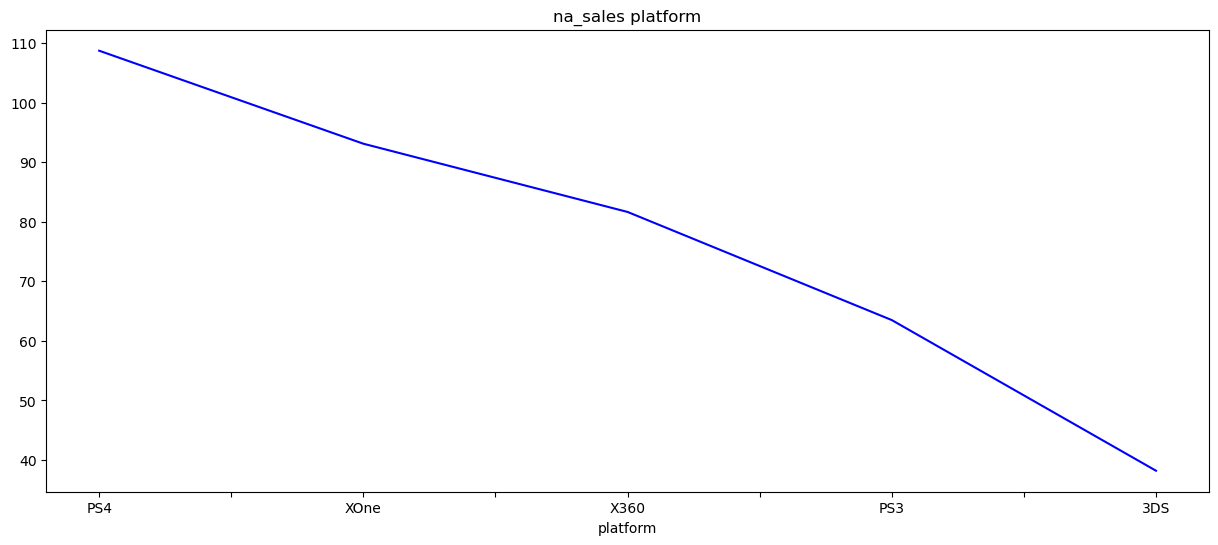

genre
Shooter     0.586845
Sports      0.305000
Platform    0.245135
Fighting    0.194375
Misc        0.177355
Name: na_sales, dtype: float64

top-5 genre ['Shooter', 'Sports', 'Platform', 'Fighting', 'Misc']


<AxesSubplot:title={'center':'na_sales genre'}, xlabel='genre'>

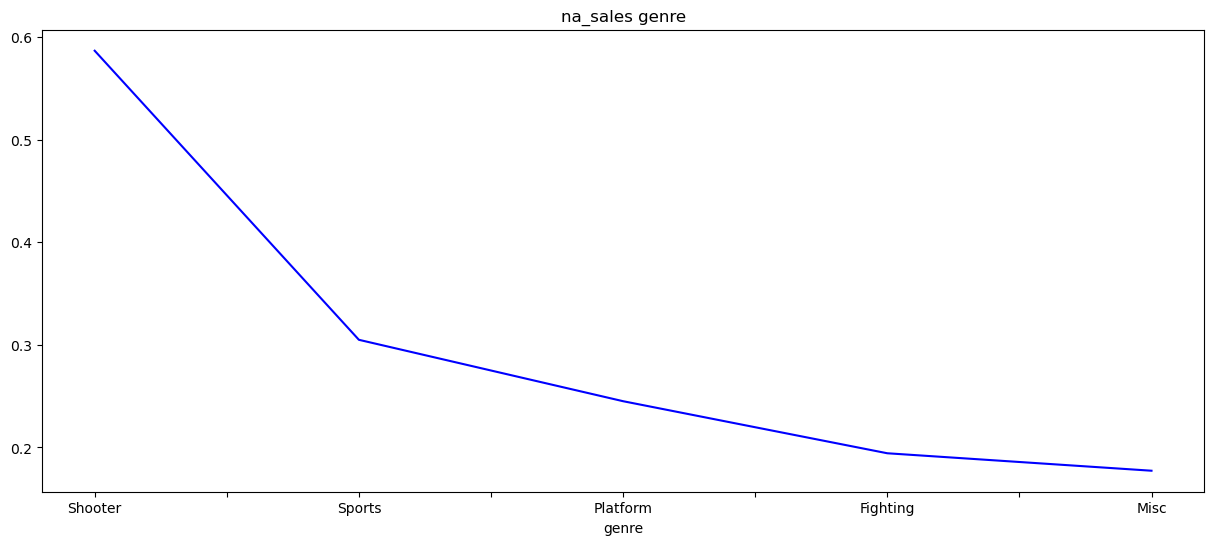

'Пользователи Европы'

platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64

top-5 platform ['PS4', 'PS3', 'XOne', 'X360', '3DS']


<AxesSubplot:title={'center':'eu_sales platform'}, xlabel='platform'>

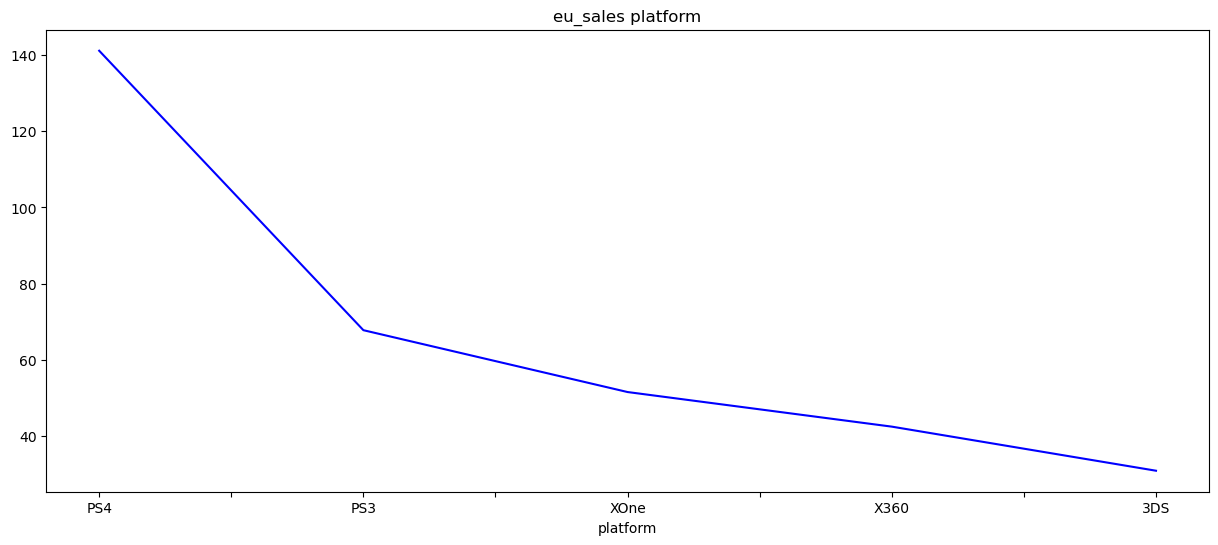

genre
Shooter       0.469840
Sports        0.282804
Racing        0.237529
Platform      0.210541
Simulation    0.176129
Name: eu_sales, dtype: float64

top-5 genre ['Shooter', 'Sports', 'Racing', 'Platform', 'Simulation']


<AxesSubplot:title={'center':'eu_sales genre'}, xlabel='genre'>

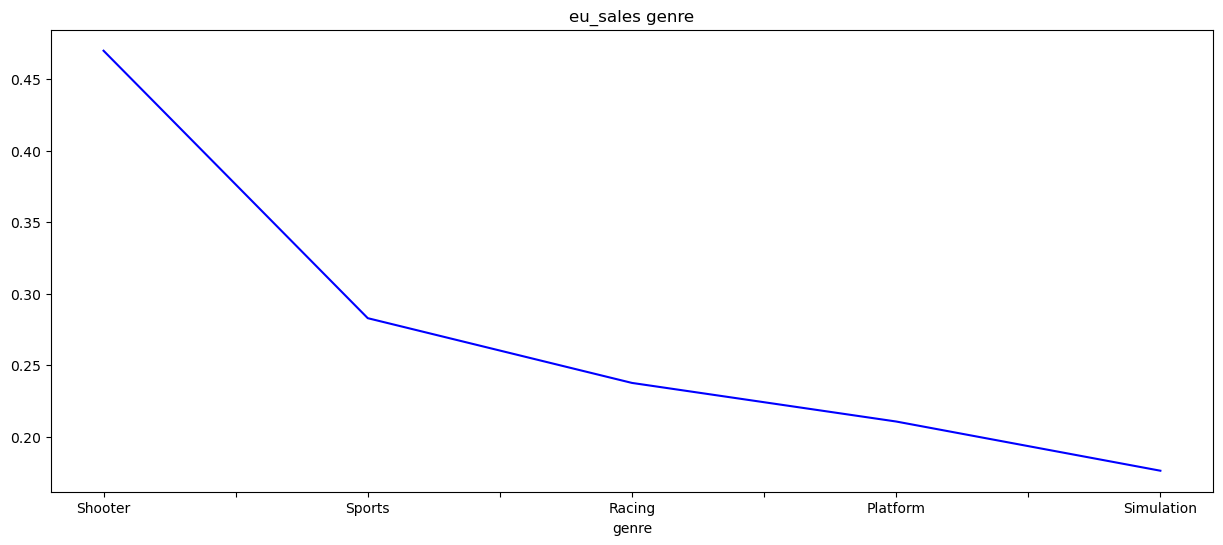

'Пользователи Японии'

platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64

top-5 platform ['3DS', 'PS3', 'PSV', 'PS4', 'WiiU']


<AxesSubplot:title={'center':'jp_sales platform'}, xlabel='platform'>

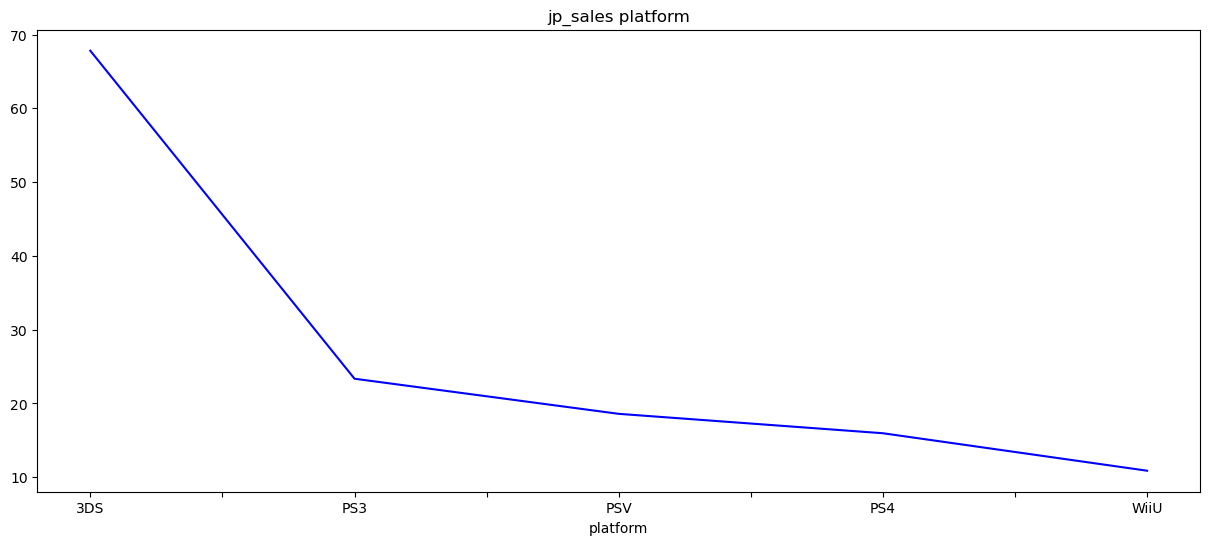

genre
Role-Playing    0.174795
Fighting        0.095625
Simulation      0.072903
Puzzle          0.069412
Platform        0.064730
Name: jp_sales, dtype: float64

top-5 genre ['Role-Playing', 'Fighting', 'Simulation', 'Puzzle', 'Platform']


<AxesSubplot:title={'center':'jp_sales genre'}, xlabel='genre'>

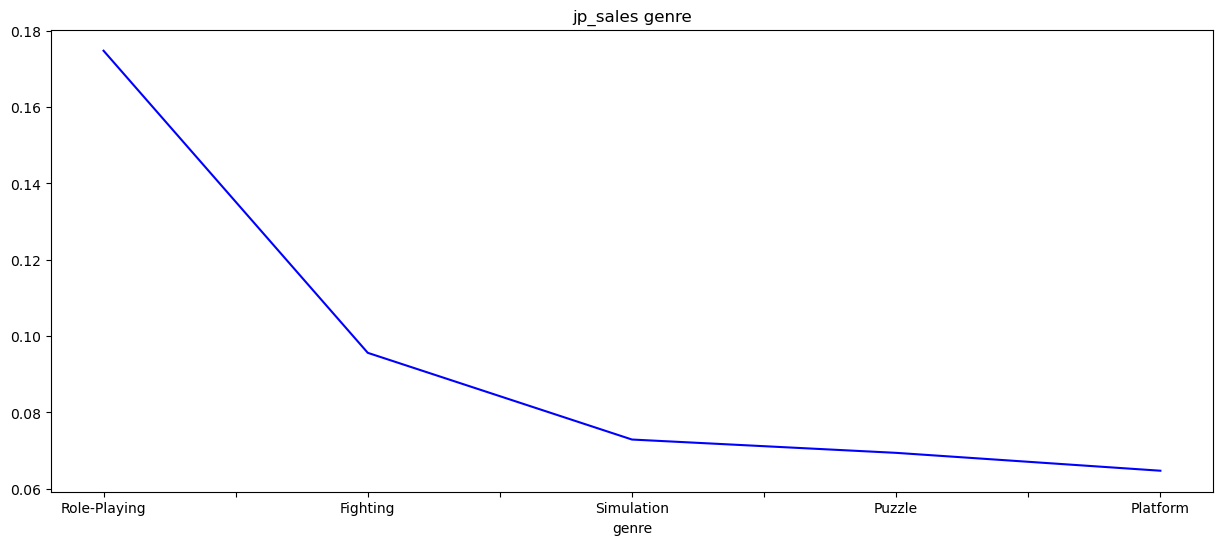

In [38]:
regions = ['na_sales','eu_sales','jp_sales']
for region in regions:
    if region == 'na_sales':
        display("Пользователи Северной Америки")
    elif region == 'eu_sales':
        display("Пользователи Европы")
    else: 
        display("Пользователи Японии")
    for i in ['platform','genre']:
        p = data.groupby(i)[region].sum().sort_values(ascending = False).head()
        g = data.groupby(i)[region].mean().sort_values(ascending = False).head()
        if i == 'platform':
            display(p)
            print('top-5', i, p.index.tolist()) # сделал print() для вывода в одну строку
            display(p.plot(figsize=(15,6), color='blue',title = region+' '+i))
            plt.show()
        else:
            display(g)
            print('top-5', i, g.index.tolist())
            display(g.plot(figsize=(15,6), color='blue',title = region+' '+i))
            plt.show()

**Пользователи Северной Америки** любят покупать игры на платформах:  `'PS4', 'X360', 'XOne', 'PS3', '3DS'`; 

В жанрах: `'Shooter', 'Sports', 'Platform', 'Misc', 'Fighting'`.

**Пользователи Европы** любят покупать игры на платформах:  `'PS4', 'PS3', 'XOne', 'X360', '3DS'`; 

В жанрах: `'Shooter', 'Racing', 'Sports', 'Platform', 'Simulation'`.

**Пользователи Японии** любят покупать игры на платформах:  `'3DS', 'PS3', 'PSV', 'PS4', 'WiiU'`; 

В жанрах: `'Role-Playing', 'Fighting', 'Simulation', 'Platform', 'Puzzle'`.

* В Северной Америке и Европе вкусы почти одинаковые, жители этих регионов предпочитают поиграть в `'Shooter', 'Sports', 'Platform'` на платформах: `'PS4', 'X360', 'XOne', 'PS3', '3DS'`;
* Во всех регионах популярны платформы: `'PS4', 'PS3', '3DS'` и жанр: `Platform`;
* В Японии же продажи распределились иначе, на первом месте `Role-Playing`. 

**Проверим влияет ли рейтинг ESRB на продажи в отдельном регионе:**

'na_sales'

,na_sales
rating,
M,165.21
no_rating,89.42
E,79.05
E10+,54.24
T,49.79


Приоритетьность рейтинга в порядке убывания: ['M', 'no_rating', 'E', 'E10+', 'T']


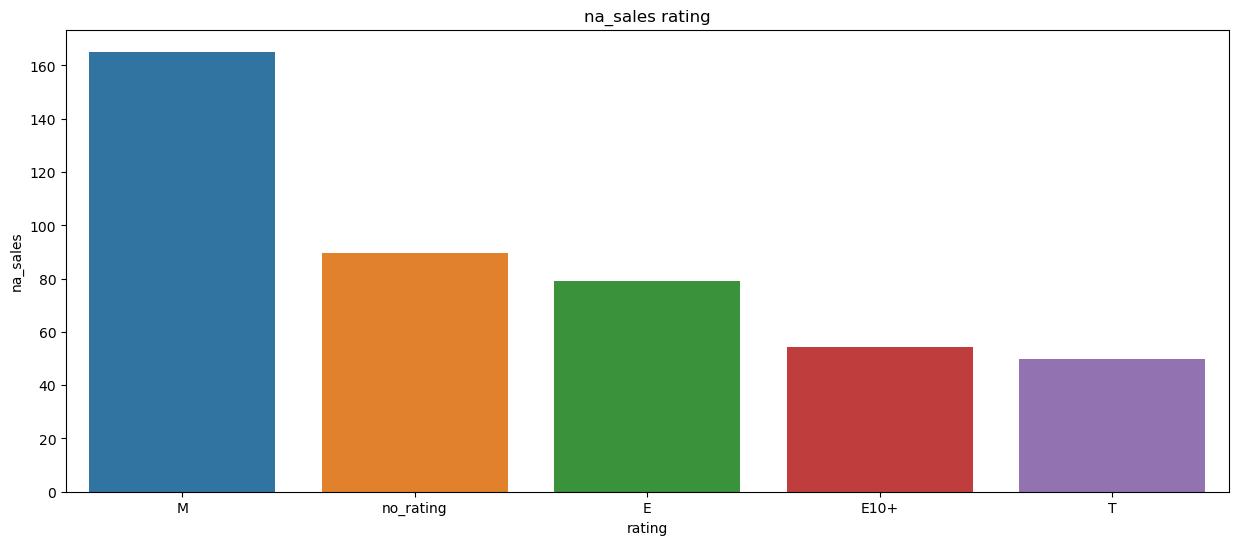

'eu_sales'

,eu_sales
rating,
M,145.32
E,83.36
no_rating,78.91
E10+,42.69
T,41.95


Приоритетьность рейтинга в порядке убывания: ['M', 'E', 'no_rating', 'E10+', 'T']


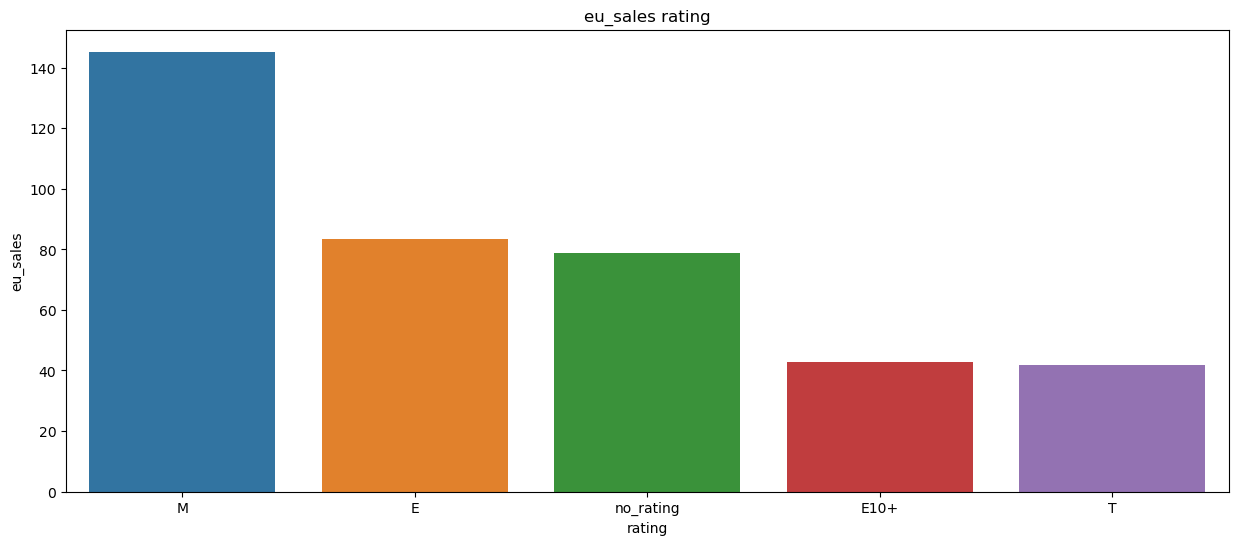

'jp_sales'

,jp_sales
rating,
no_rating,85.05
T,20.59
E,15.14
M,14.11
E10+,5.89


Приоритетьность рейтинга в порядке убывания: ['no_rating', 'T', 'E', 'M', 'E10+']


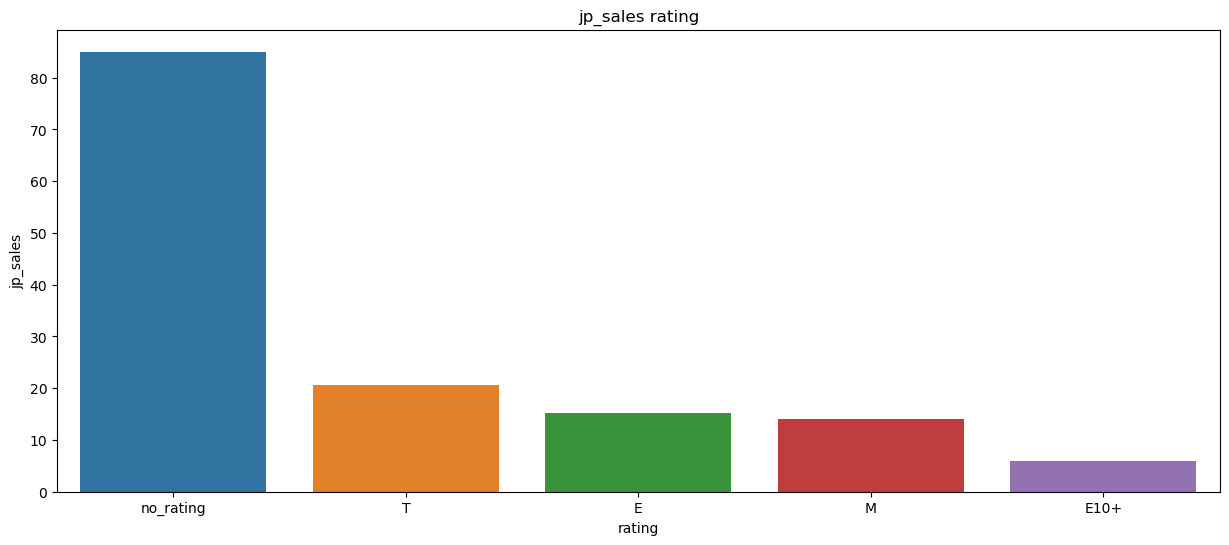

In [41]:
for region in regions:
    display(region)
    r = data.pivot_table(index='rating', values= region, aggfunc='sum').sort_values(by=region, ascending=False)
    display(r)
    print('Приоритетьность рейтинга в порядке убывания:',r.index.tolist())
    plt.figure(figsize=(15,6))
    sns.barplot(data = r, x = r.index, y = r[region]);
    plt.title(region+' rating')
    plt.show()

Рейтинг ESRB практически не влияет на продажи в регионах, по полученным данным можем утверждать:
* Северная Америка и Европа вновь оказались очень похожи друг на друга, приоритетьность рейтинга в порядке убывания: `'M', 'no_rating', 'E', 'E10+', 'T';
* Япония в своем репертуаре, практически противоположные данные по сравнению с другими регионами, большая часть игр - без рейтинга. То есть наличие рейтинговой отметки по данным ESBN для этой страны не очень то и важно. Приоритетьность рейтинга в порядке убывания: `'no_rating', 'T', 'E', 'M', 'E10+'`.

**Выводы:**
* В Северной Америке и Европе вкусы почти одинаковые, жители этих регионов предпочитают поиграть в `'Shooter', 'Sports', 'Platform'` на платформах: `'PS4', 'X360', 'XOne', 'PS3', '3DS'`;
* Во всех регионах популярны платформы: `'PS4', 'PS3', '3DS'` и жанр: `Platform`;
* В Японии же продажи распределились иначе, на первом месте `Role-Playing`. 
* Северная Америка и Европа вновь оказались очень похожи друг на друга, приоритетьность рейтинга в порядке убывания: `'M', 'no_rating', 'E', 'E10+', 'T'`;
* Япония в своем репертуаре, практически противоположные данные по сравнению с другими регионами, большая часть игр - без рейтинга. То есть наличие рейтинговой отметки по данным ESBN для этой страны не очень то и важно. Приоритетьность рейтинга в порядке убывания: `'no_rating', 'T', 'E', 'M', 'E10+'`.

**Портрет пользователя Северной Америки:**

- Человек, попадающий под категорию:  `'M', 'no_rating', 'E', 'E10+', 'T'`(рейтинг прописан в порядке убывания количества продаж); 
- Играющий на платформе: `'PS4', 'X360', 'XOne', 'PS3', '3DS'`(платформа прописана в порядке убывания количества продаж); 
- В игры жанром `'Shooter', 'Sports', 'Platform', 'Misc', 'Fighting'`(жанр прописан в порядке убывания количества продаж).

**Портрет пользователя Европы:**

- Человек, попадающий под категорию:  `'M', 'E', 'no_rating', 'E10+', 'T'`(рейтинг прописан в порядке убывания количества продаж); 
- Играющий на платформе: `'PS4', 'X360', 'XOne', 'PS3', '3DS'`(платформа прописана в порядке убывания количества продаж); 
- В игры жанром `'Shooter', 'Sports', 'Platform', 'Misc', 'Fighting'`(жанр прописан в порядке убывания количества продаж).

**Портрет пользователя Японии:**

- Человек, попадающий под категорию:  `E, T, M, E10+`(рейтинг прописан в порядке убывания количества продаж); 
- Играющий на платформе: `'3DS', 'PS3', 'PSV', 'PS4', 'WiiU'`(платформа прописана в порядке убывания количества продаж); 
- В игры жанром `'Role-Playing', 'Fighting', 'Simulation', 'Platform', 'Puzzle'`(жанр прописан в порядке убывания количества продаж).

## 3. Проверка гипотез.

Проверим гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:

In [42]:
display(data.head())
data['platform'].unique()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no_rating,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

H_0: Пользовательский рейтинг (user_score) платформы Xbox One = Пользовательский рейтинг (user_score) платформы PC

H_1: Пользовательский рейтинг (user_score) платформы Xbox One ≠ Пользовательский рейтинг (user_score) платформы PC

alpha = 0.05

In [43]:
data_no_nan = data.loc[~(data['user_score'].isna())]
results = st.ttest_ind(data_no_nan.loc[data_no_nan['platform']=='XOne','user_score'],\
data_no_nan.loc[data_no_nan['platform']=='PC','user_score'])# results = вызов метода для проверки гипотезы

alpha = .05# alpha = задайте значение уровня значимости

print(results.pvalue)# вывод значения p-value на экран 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')# условный оператор с выводом строки с ответом

0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
Средние пользовательские рейтинги платформ Xbox One и PC **cтатистически значимо не различаются**.

Проверим гипотезу: Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») разные.

H_0: Пользовательский рейтинг (user_score) жанра `Action` = Пользовательский рейтинг (user_score) жанра `Sports`.

H_1: Пользовательский рейтинг (user_score) жанра `Action` ≠ Пользовательский рейтинг (user_score) жанра `Sports`.

alpha = 0.05

In [44]:
results = st.ttest_ind(data_no_nan.loc[data_no_nan['genre']=='Action','user_score'],\
data_no_nan.loc[data_no_nan['genre']=='Sports','user_score'])# results = вызов метода для проверки гипотезы

alpha = .05# alpha = задайте значение уровня значимости

print(results.pvalue)# вывод значения p-value на экран 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')# условный оператор с выводом строки с ответом

1.0517832389140023e-27
Отвергаем нулевую гипотезу


**Вывод:**
Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») **статистически значимо не различаются**.

## Общий вывод:

Мы провели исследование, выявили определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В нашем расспоряении данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) мы получили из файла games.csv

В каждой строке таблицы — данные о игре. Часть колонок описывает саму игру: название, жанр, год выпуска, оценка критиков, оценка пользователей и возрастное ограничение по данным ESRB. Остальные данные рассказывают о продажах: в каком регионе сколько было продано копий.



Рейтинг ESRB:

«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».

«E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первой игрой, которая получила данный рейтинг, стала The Simpsons Cartoon Studio, выпущенная в 1996 году.

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года. Первой игрой, которая получила данный рейтинг, стала Donkey Kong: Jungle Beat.

«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

«M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением. Большинство таких игр предназначено для персональных компьютеров под управлением Microsoft Windows и Apple Macintosh. Рейтинг «Только для взрослых» является предметом многочисленных дискуссий, так как накладывает серьёзные ограничения на продажи игры. Первой игрой, которая получила данный рейтинг, стала The Joy of Sex, выпущенная в 1993 году.

«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

«RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»: Продукт отправлен ESRB на оценку, но примерное содержание близко к рейтингу «M». Данная маркировка была введена с 2021 г. и распространяется на демо или презентационный вариант.

(Источник: https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board)

### Провели предобработку данных:

Предобработка обнаружила две проблемы в данных:

- нарушения в стиле заголовков,
- пропущенные значения.

Мы исправили заголовки, чтобы упростить работу с таблицей.

Часть пропущенных значения оставили как есть, чтобы не исказить данные и не прийти к неверному выводу. 

Пропуске в столбце `rating` за менили на `no_rating`, так как данные нам не известы, а заменить их на "что-то среднее" неправильно, по той причине что рейтинг ESBN строиться для США и Канады, а мы изучием не только их.

Удалили те строки, где пропущенные значения заполнить не представляется возможным, но они не повлияют на ход исследования так как их менее 2%. 


### Провели исследовательский анализ данных:

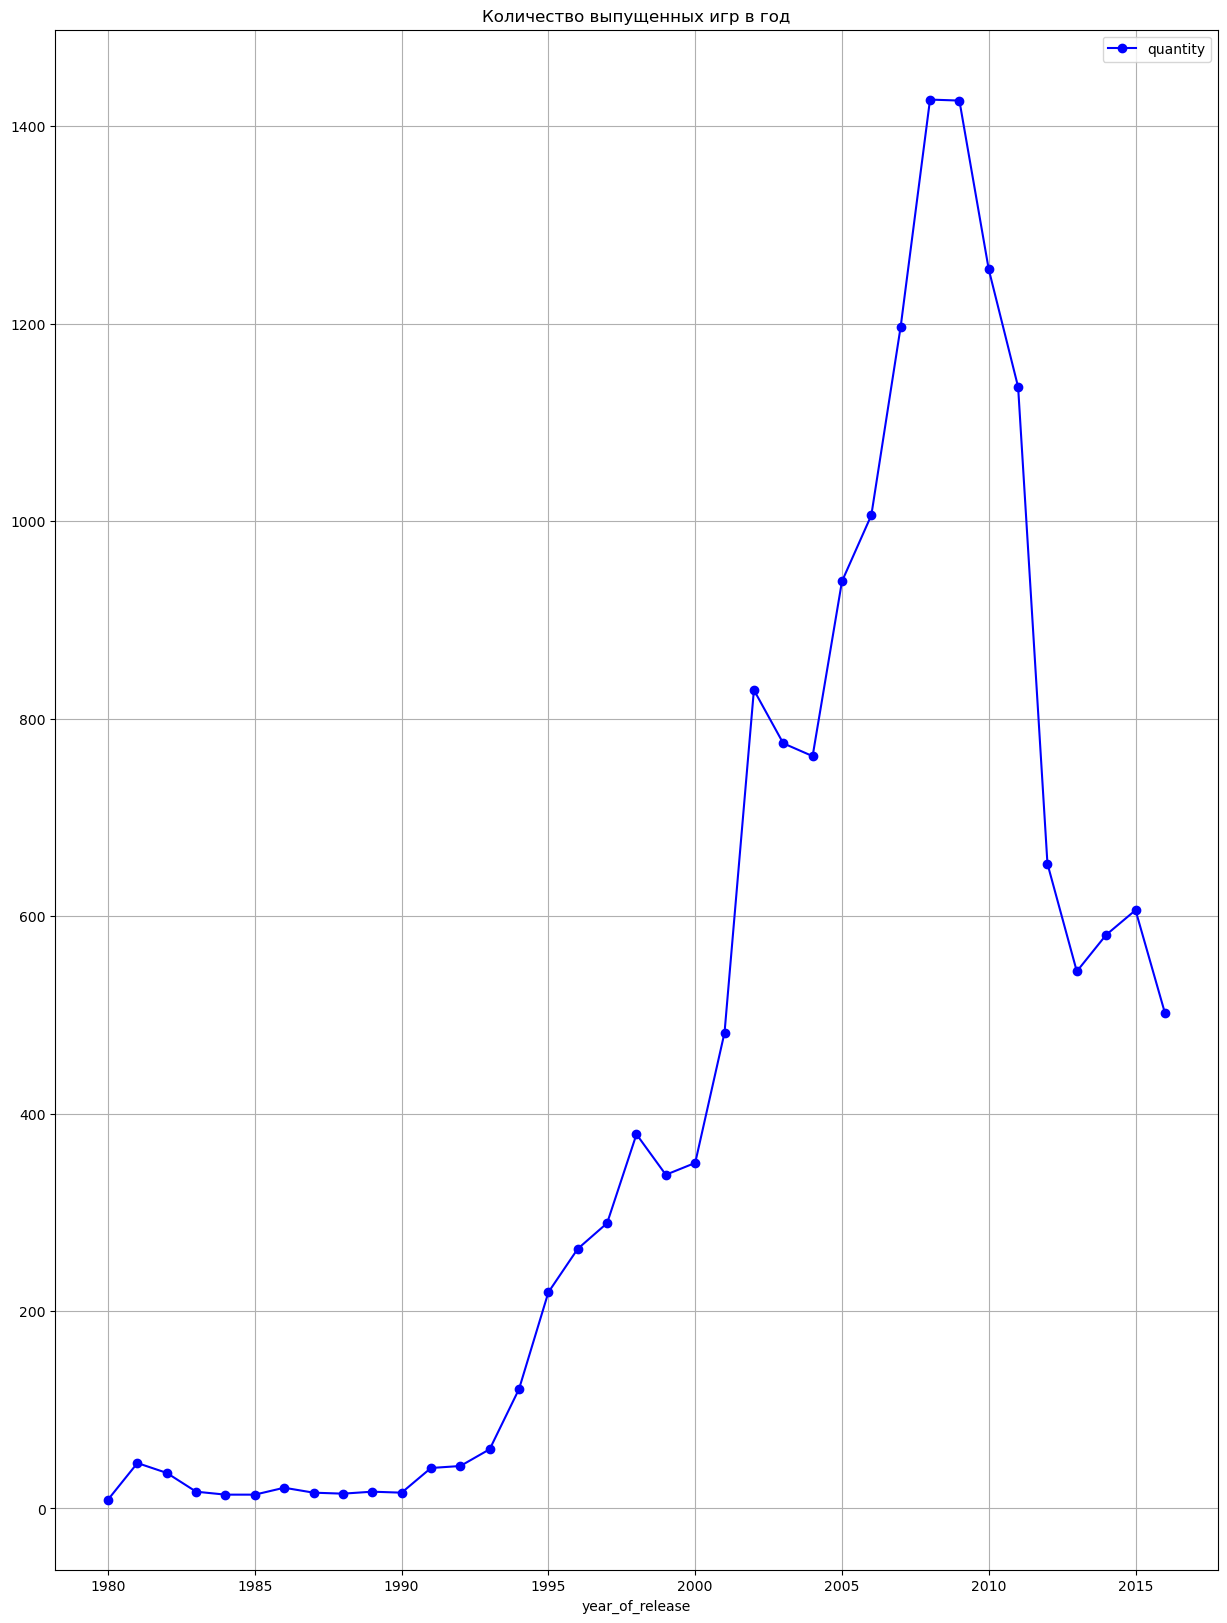

In [45]:
quantity_games.plot(style = 'o-', c ='blue', grid = True, figsize = (15,20), title='Количество выпущенных игр в год' )
plt.show()

Для прогнозирования рекламной компании на 2017 год, нам потребуются данные с действующими платформами. Что бы понять какие платформы имеют перспективы роста, возьмем за актуальный период данные с 2013 по 2016 годы. Периоды за предыдущие периоды не берем так сможем понять какие именно платформы будут расти дальше, что видно на графике с распределением продаж по годам.

* Взяли за актуальный период с 2013 по 2016 годы.

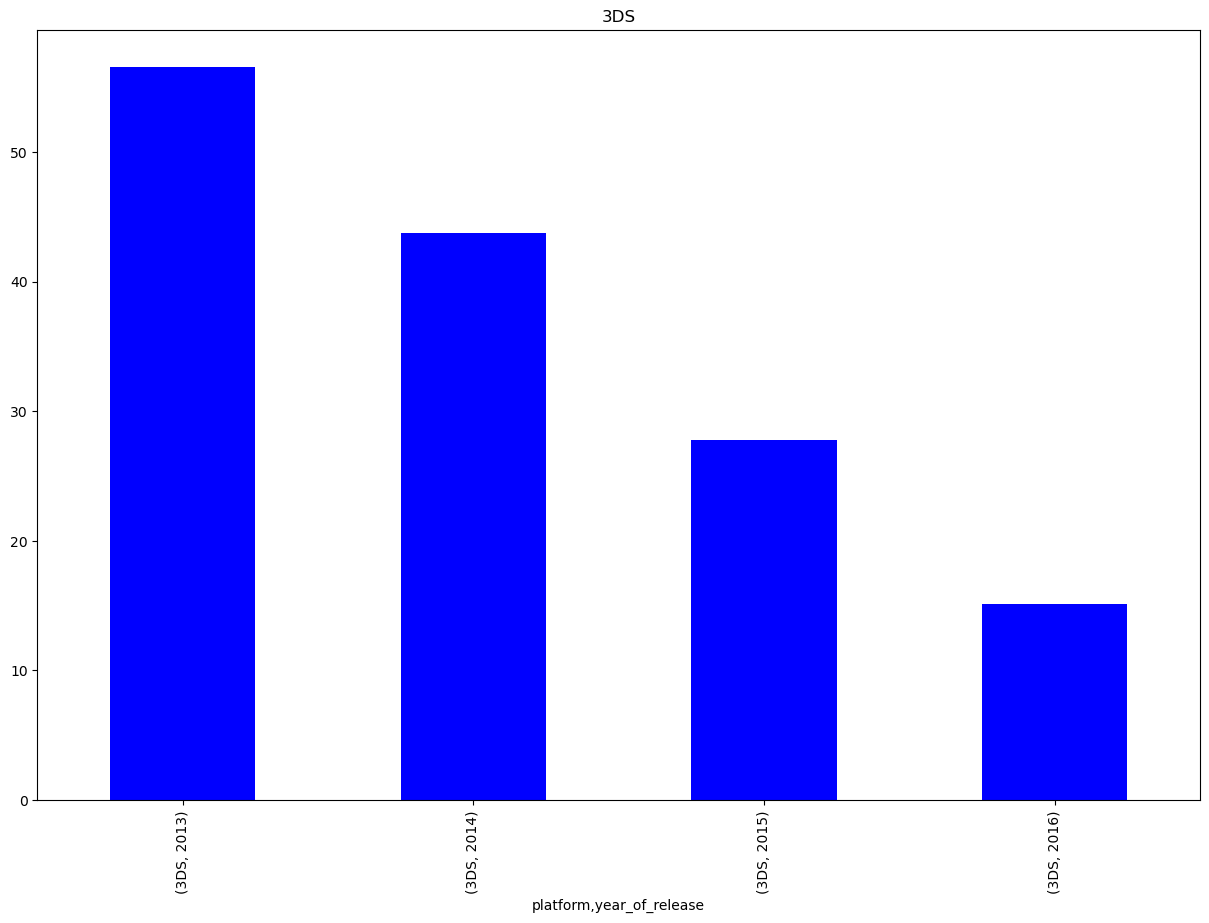

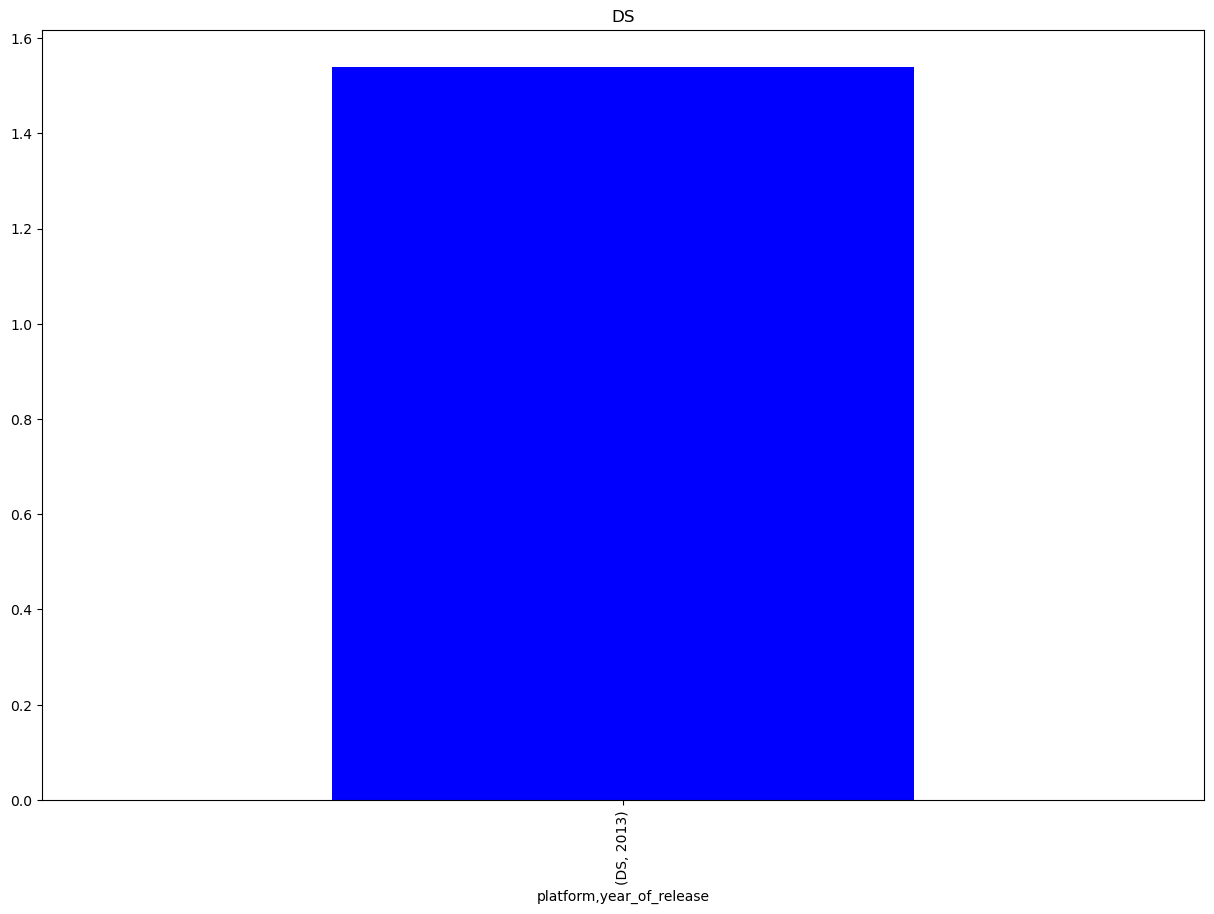

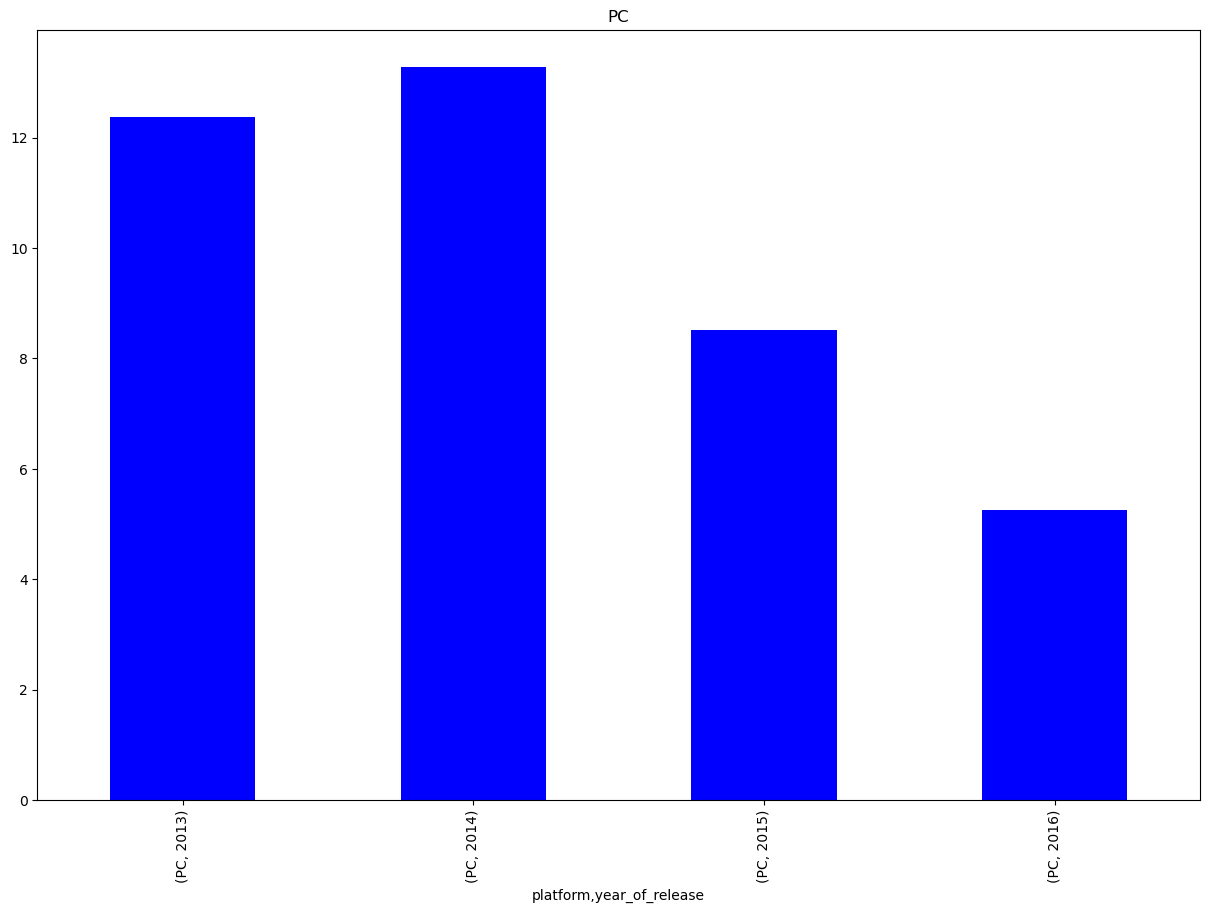

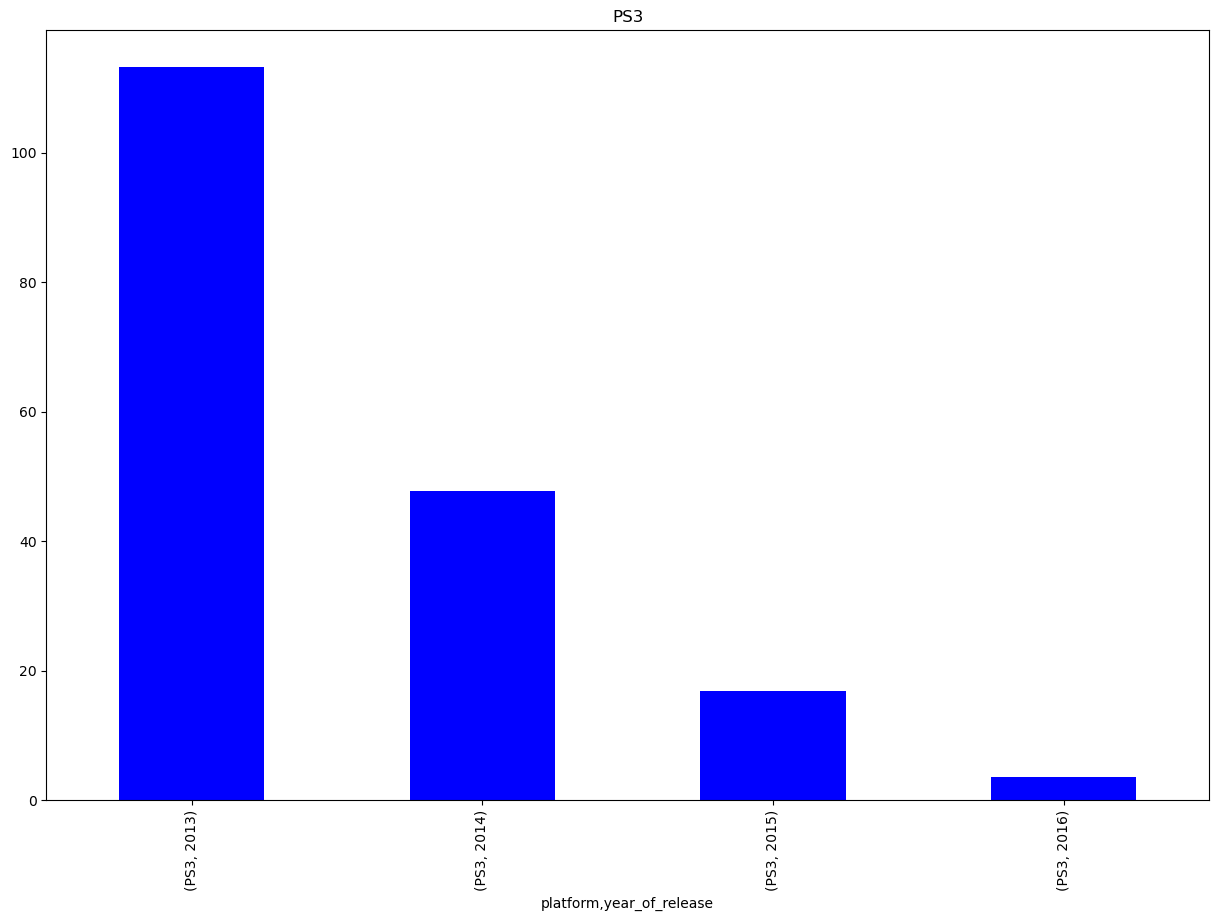

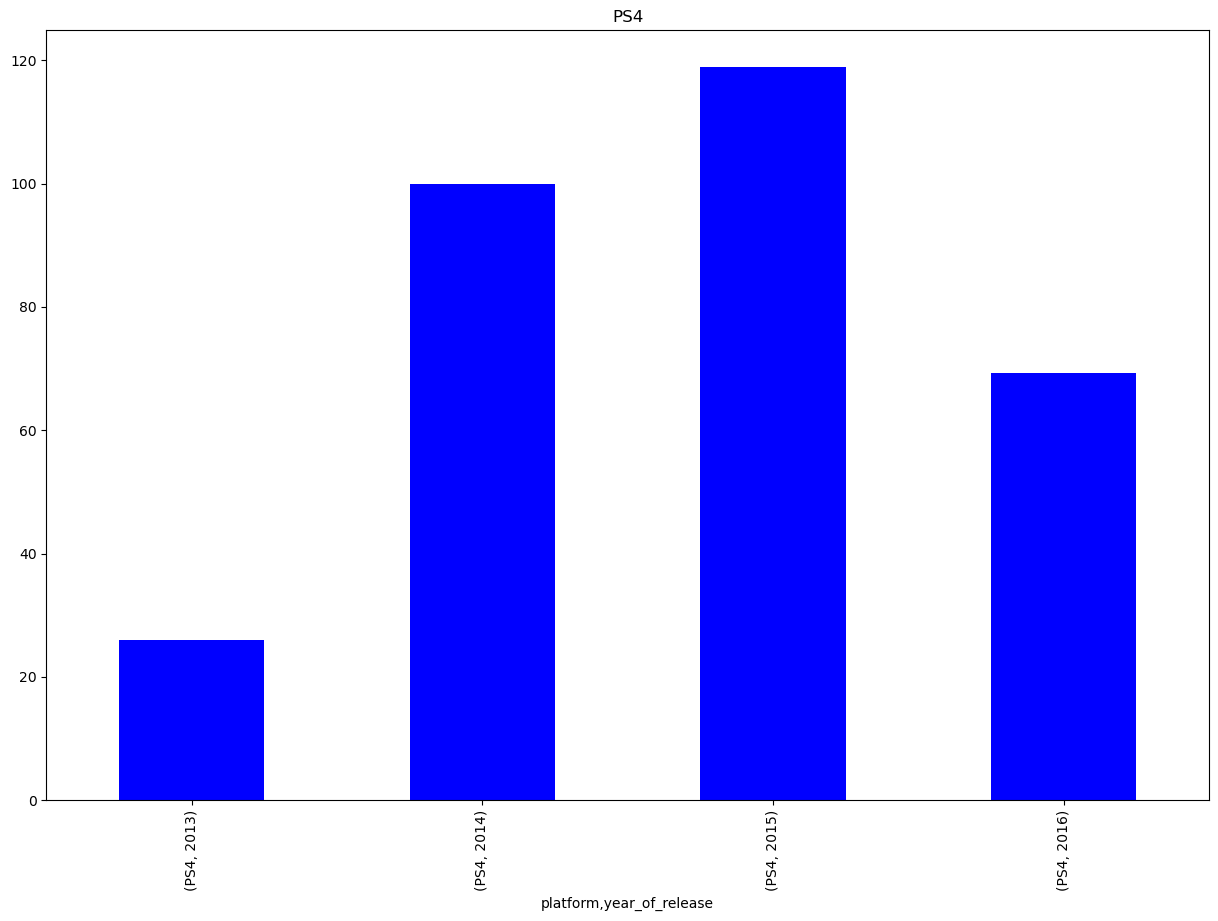

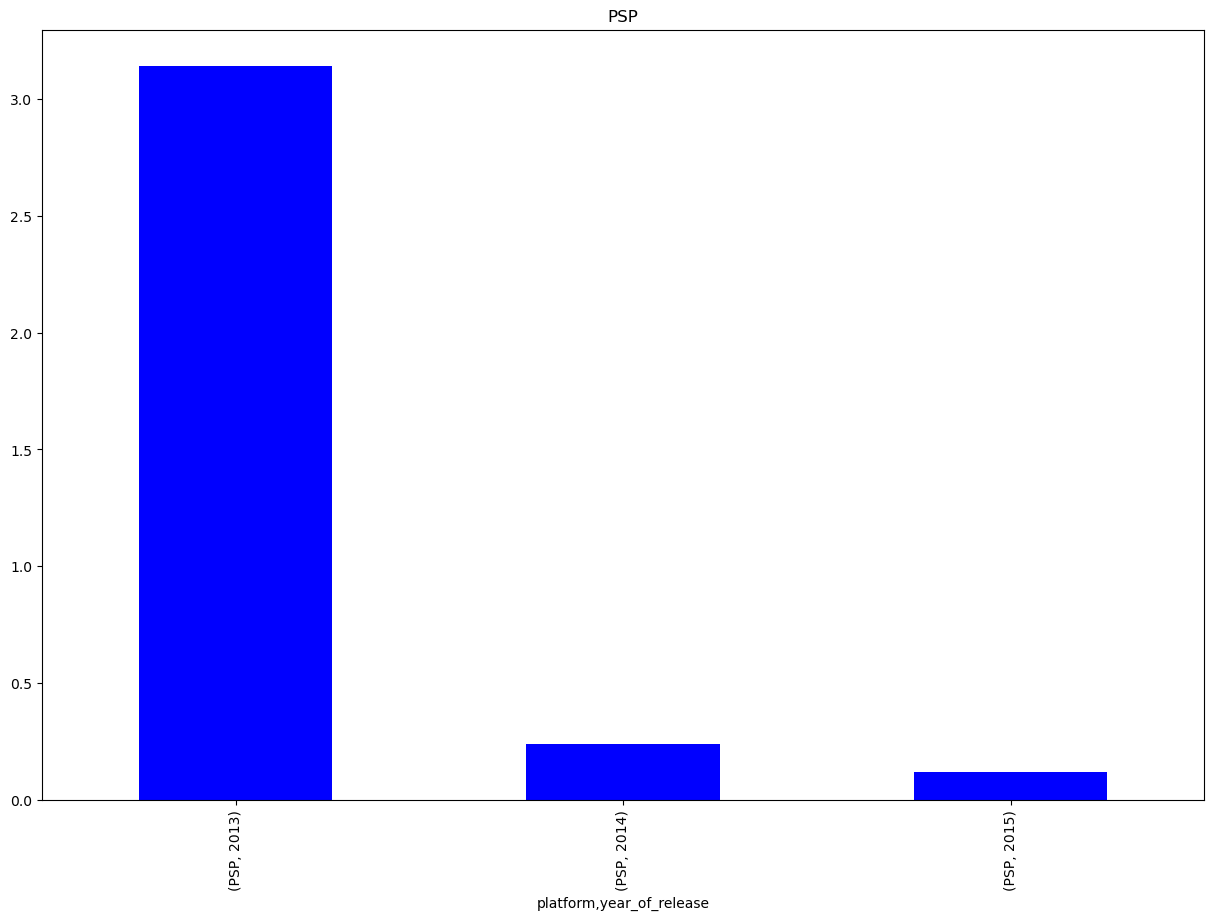

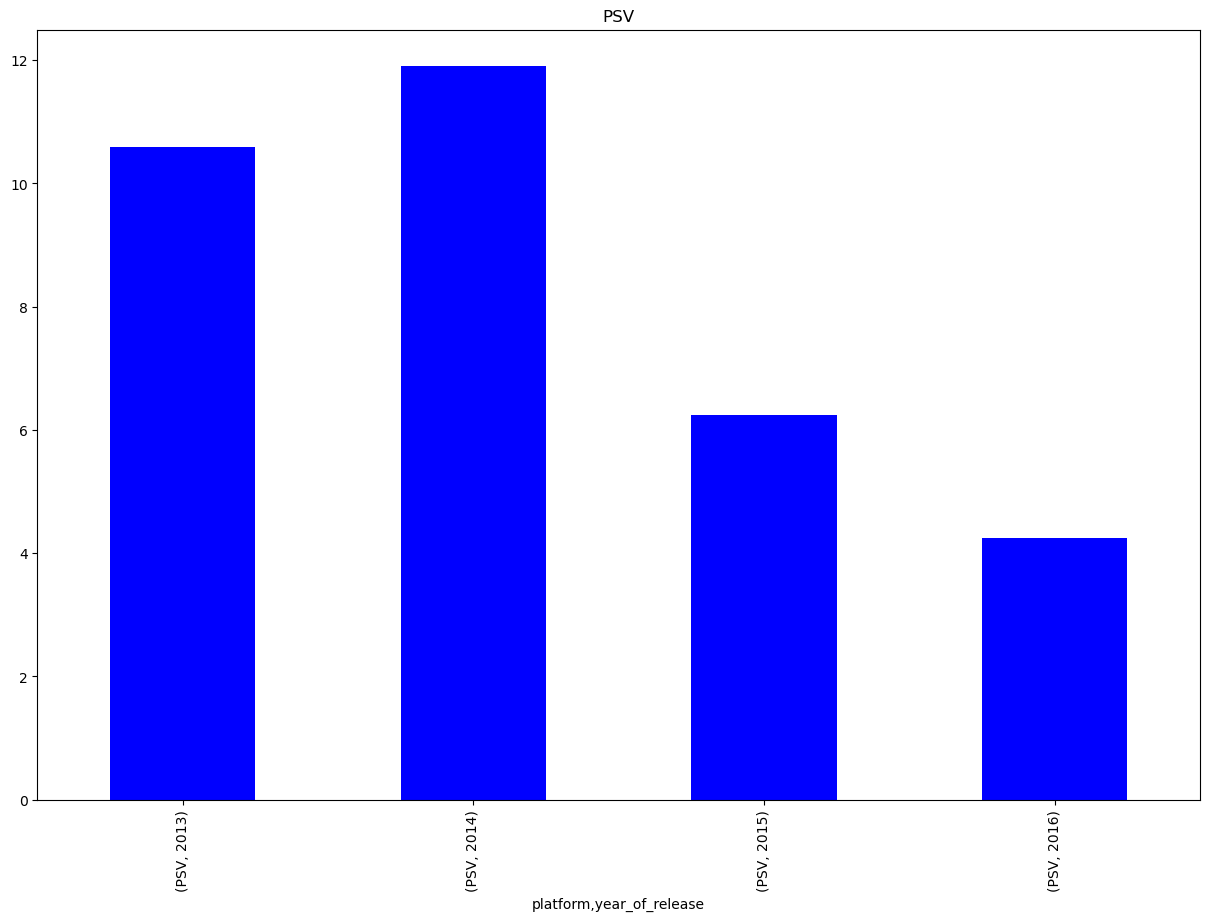

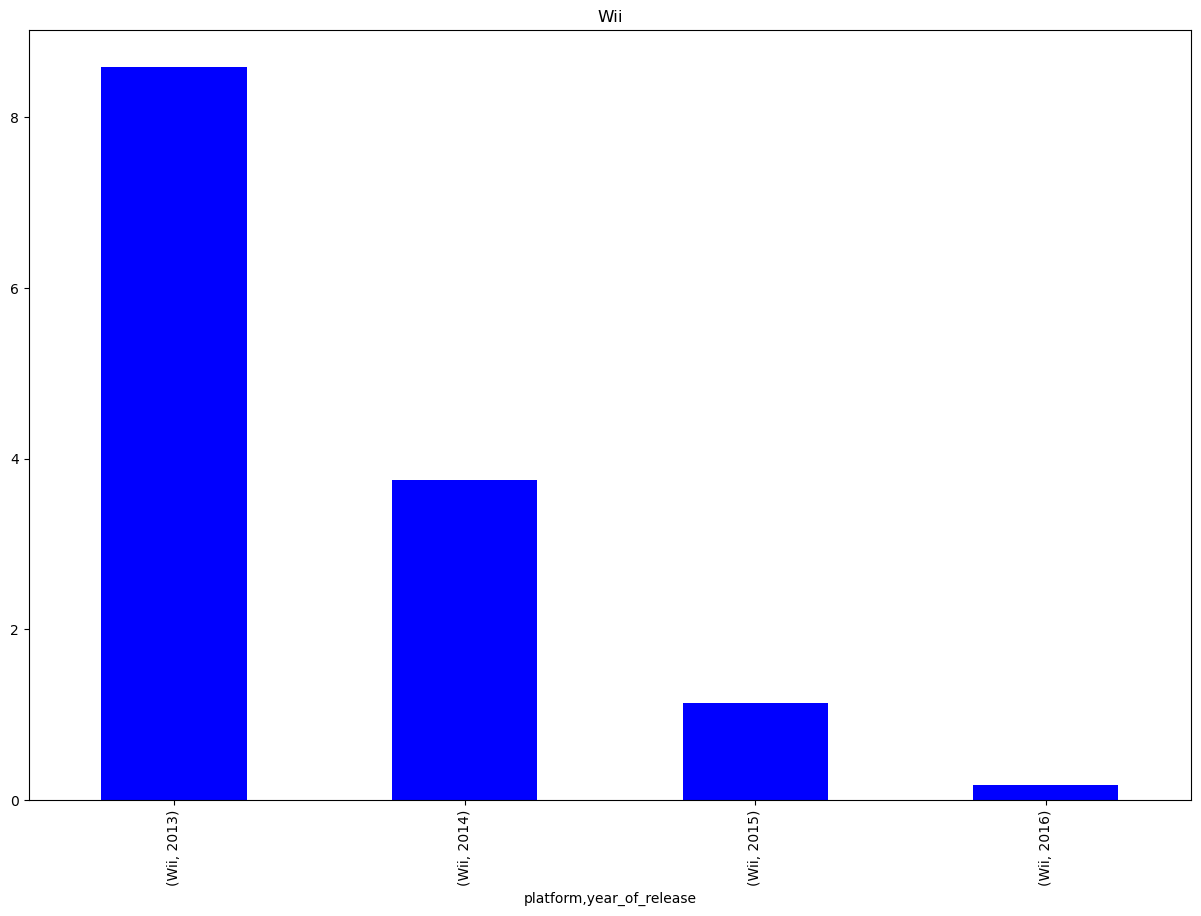

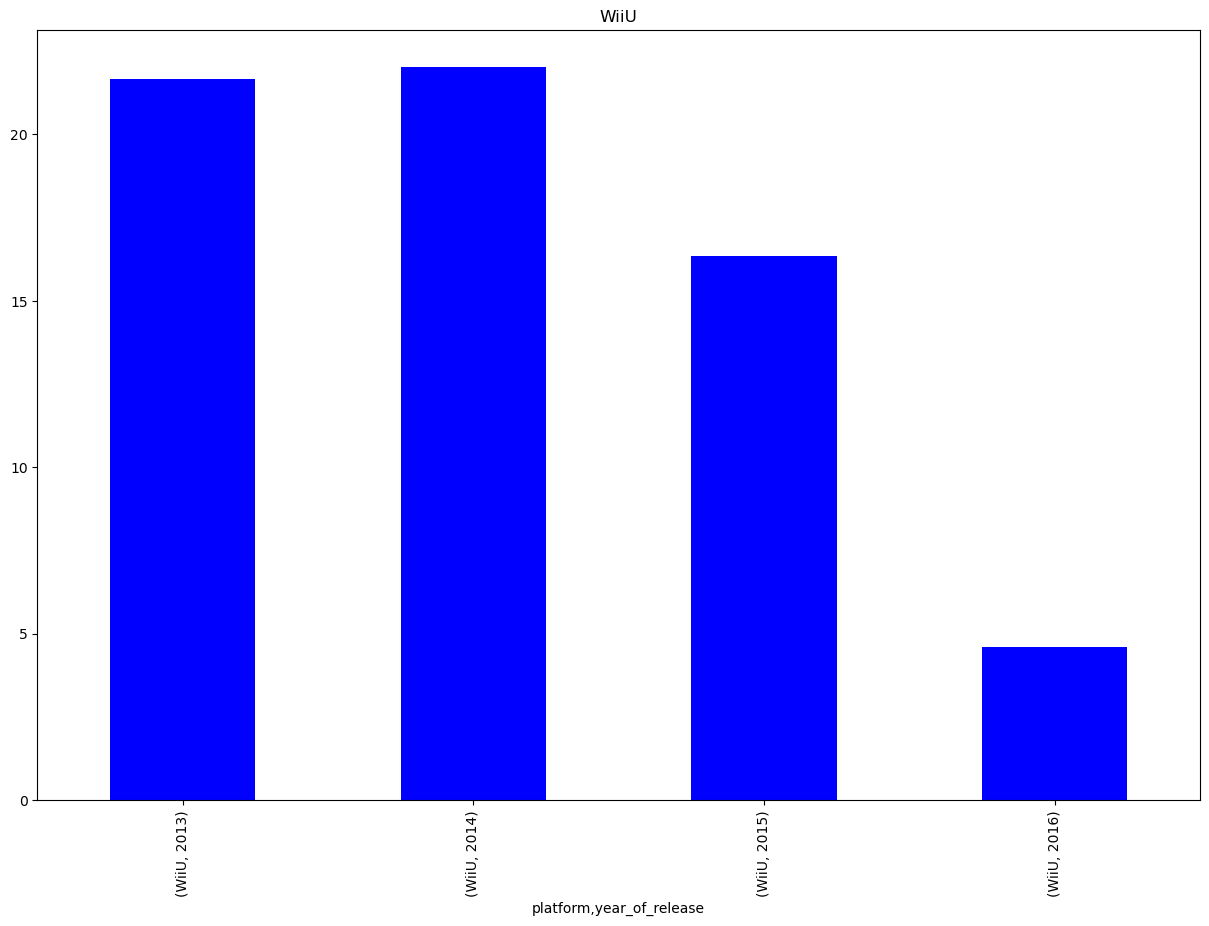

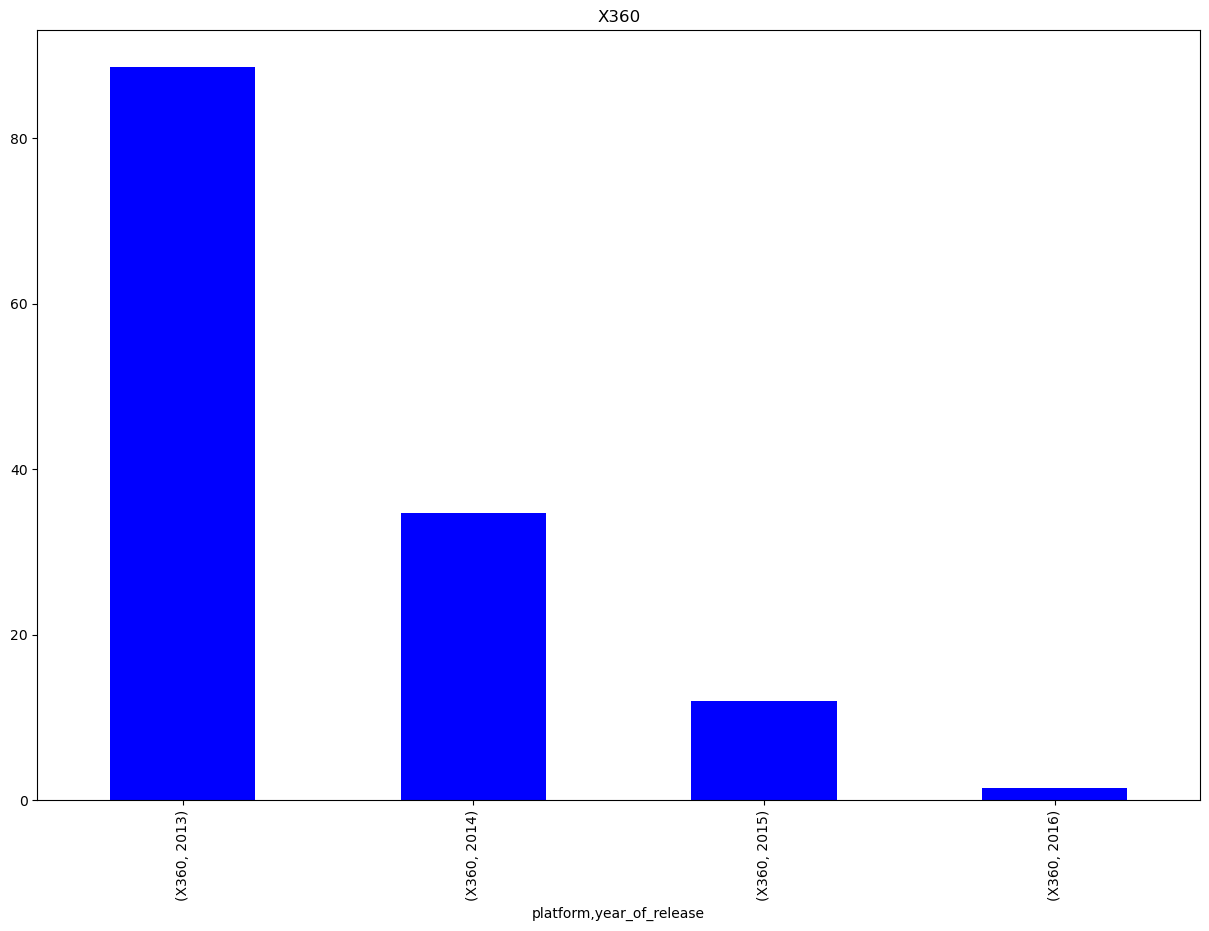

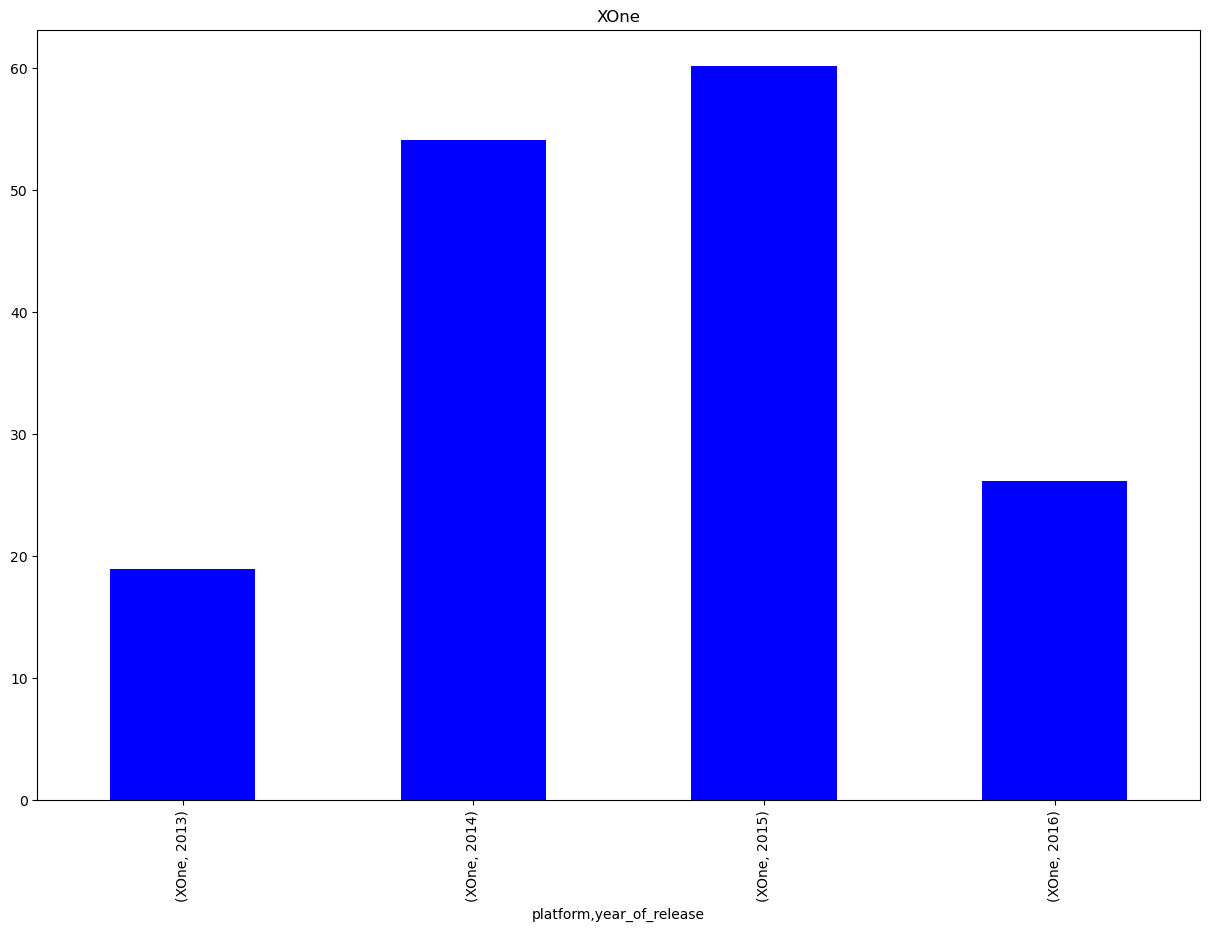

In [46]:
for i in current_platforms.index.tolist():
    data.loc[data['platform'] == i].groupby(['platform','year_of_release'])['total_sales'].sum() \
    .plot(kind='bar',color = 'blue', figsize = (15,10), title = i)
    plt.show()

* Выявлены 10 платформ с наибольшими суммарными продажами: ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS4', 'GBA', 'PSP', '3DS', 'XB'];
* Наибольшее количество копий игр было проданно платформой PS2 в 2004 году;
* Характерный срок появления новых и исчезновения старых платформ - 10 лет;
* На продажи практически не влияет оценка пользователей;
* Продажи слабо зависят от оценки критиков;
* Так же можем сделать вывод что есть положительная зависимость между оценкой критиков и оценкой пользователей.

Выявленны потенциально прибыльные платформы:
* PS4. Лидер продаж 2016 года данная платформа на момент анализа достаточно молода и у нее еще все впереди;
* XOne. Почти четверть продаж в 2016 году пришлось на эту модель. Хоть и она не попала в предыдущий рейтинг, является потенциально прибыльной;
* 3DS. Еще минимум 3 года будет существовать, продажи на высоком уровне.

### Рассмотрели каждый регион в отдельности и составили портрет пользователя каждого региона:

* В Северной Америке и Европе вкусы почти одинаковые, жители этих регионов предпочитают поиграть в `'Shooter', 'Sports', 'Platform'` на платформах: `'PS4', 'X360', 'XOne', 'PS3', '3DS'`;
* Во всех регионах популярны платформы: `'PS4', 'PS3', '3DS'` и жанр: `Platform`;
* В Японии же продажи распределились иначе, на первом месте `Role-Playing`. 
* Северная Америка и Европа вновь оказались очень похожи друг на друга, приоритетьность рейтинга в порядке убывания: `'M', 'no_rating', 'E', 'E10+', 'T'`;
* Япония в своем репертуаре, практически противоположные данные по сравнению с другими регионами, большая часть игр - без рейтинга. То есть наличие рейтинговой отметки по данным ESBN для этой страны не очень то и важно. Приоритетьность рейтинга в порядке убывания: `'no_rating', 'T', 'E', 'M', 'E10+'`.

**Портрет пользователя Северной Америки:**

- Человек, попадающий под категорию:  `'M', 'no_rating', 'E', 'E10+', 'T'`(рейтинг прописан в порядке убывания количества продаж); 
- Играющий на платформе: `'PS4', 'X360', 'XOne', 'PS3', '3DS'`(платформа прописана в порядке убывания количества продаж); 
- В игры жанром `'Shooter', 'Sports', 'Platform', 'Misc', 'Fighting'`(жанр прописан в порядке убывания количества продаж).

**Портрет пользователя Европы:**

- Человек, попадающий под категорию:  `'M', 'E', 'no_rating', 'E10+', 'T'`(рейтинг прописан в порядке убывания количества продаж); 
- Играющий на платформе: `'PS4', 'X360', 'XOne', 'PS3', '3DS'`(платформа прописана в порядке убывания количества продаж); 
- В игры жанром `'Shooter', 'Sports', 'Platform', 'Misc', 'Fighting'`(жанр прописан в порядке убывания количества продаж).

**Портрет пользователя Японии:**

- Человек, попадающий под категорию:  `E, T, M, E10+`(рейтинг прописан в порядке убывания количества продаж); 
- Играющий на платформе: `'3DS', 'PS3', 'PSV', 'PS4', 'WiiU'`(платформа прописана в порядке убывания количества продаж); 
- В игры жанром `'Role-Playing', 'Fighting', 'Simulation', 'Platform', 'Puzzle'`(жанр прописан в порядке убывания количества продаж).

### Перед проведением исследования были выдвинуты гипотезы:

**1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

**2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

Обе гипотезы при проведении статистического анализа пришлось отвергнуть в пользу альтернативных:

1. Средние пользовательские рейтинги платформ Xbox One и PC **cтатистически значимо не различаются**.

2. Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») **статистически значимо не различаются**.

### Общие рекомендации:

1. Развивать рекламму платформ: PS4, XOne, 3DS;
2. Для Северной Америки и Европы делать однотипную рекламму;
3. Разработать для Японии отдельную рекламму без рейтинга ESRB;
4. По возможности обратить внимание на оценки критиков.